Import Libraries and Connect too the Databases

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Blink Detection/Datasets/BLINKData_Labeled'
print("Data directory contents:", os.listdir(data_dir))
folders = ['EEG-IO', 'EEG-VR', 'EEG-VV']

all_data_eeg = []

db_name = '/content/drive/MyDrive/Blink Detection/Datasets/BLINKData_Labeled.db'
conn = sqlite3.connect(db_name)

# Primary Loop

Mounted at /content/drive
Data directory contents: ['EEG-IO', 'EEG-VR', 'EEG-VV']


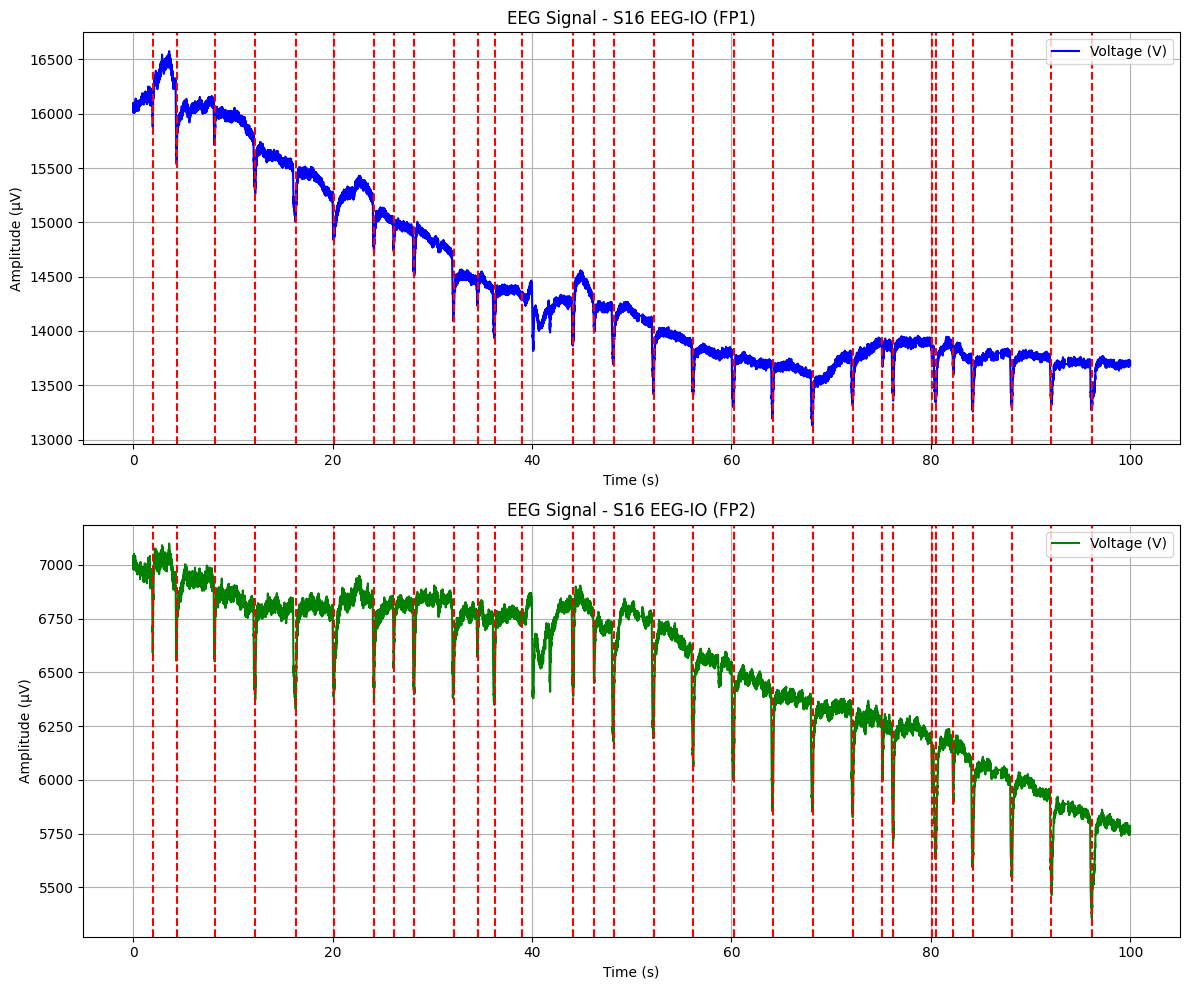

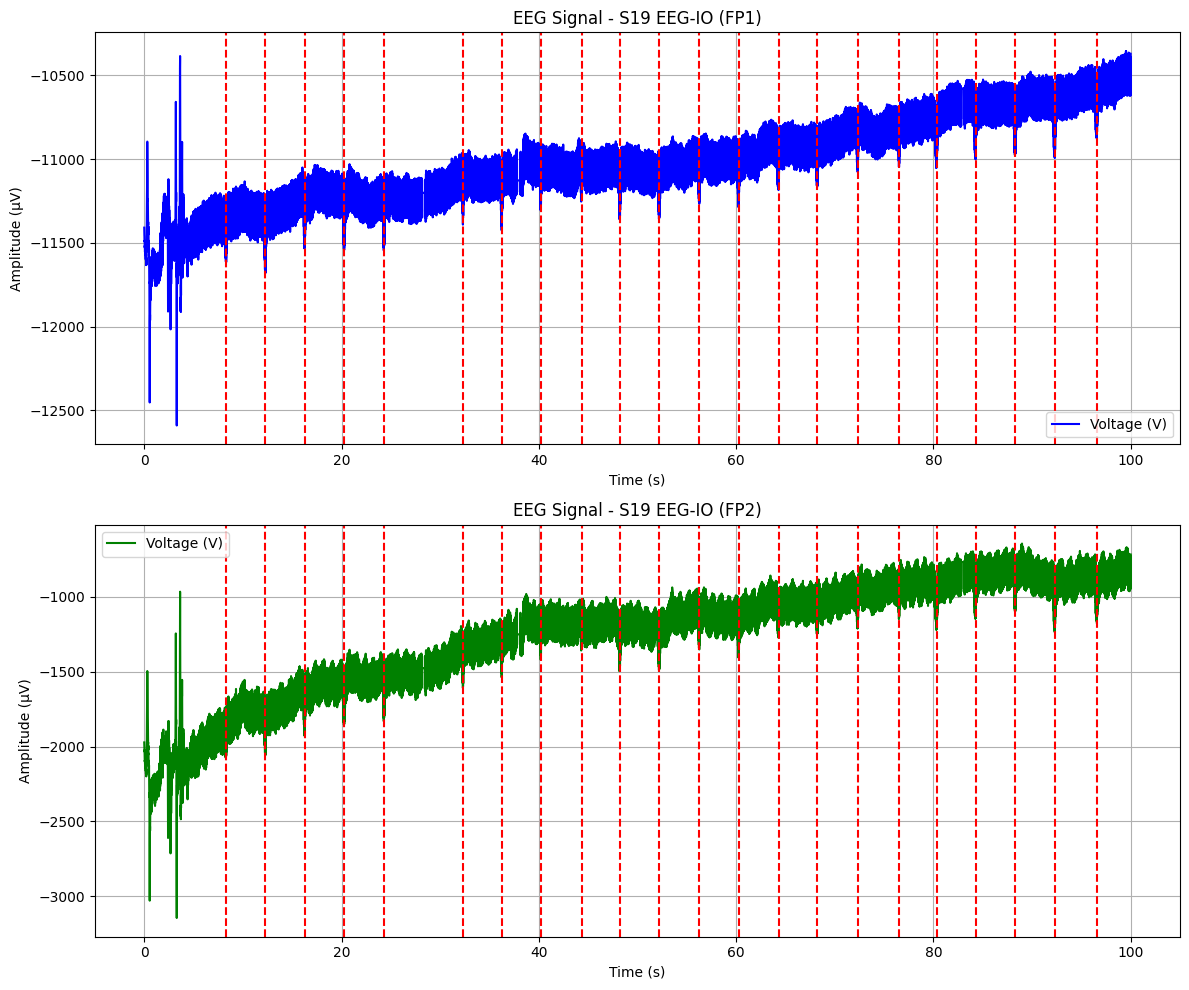

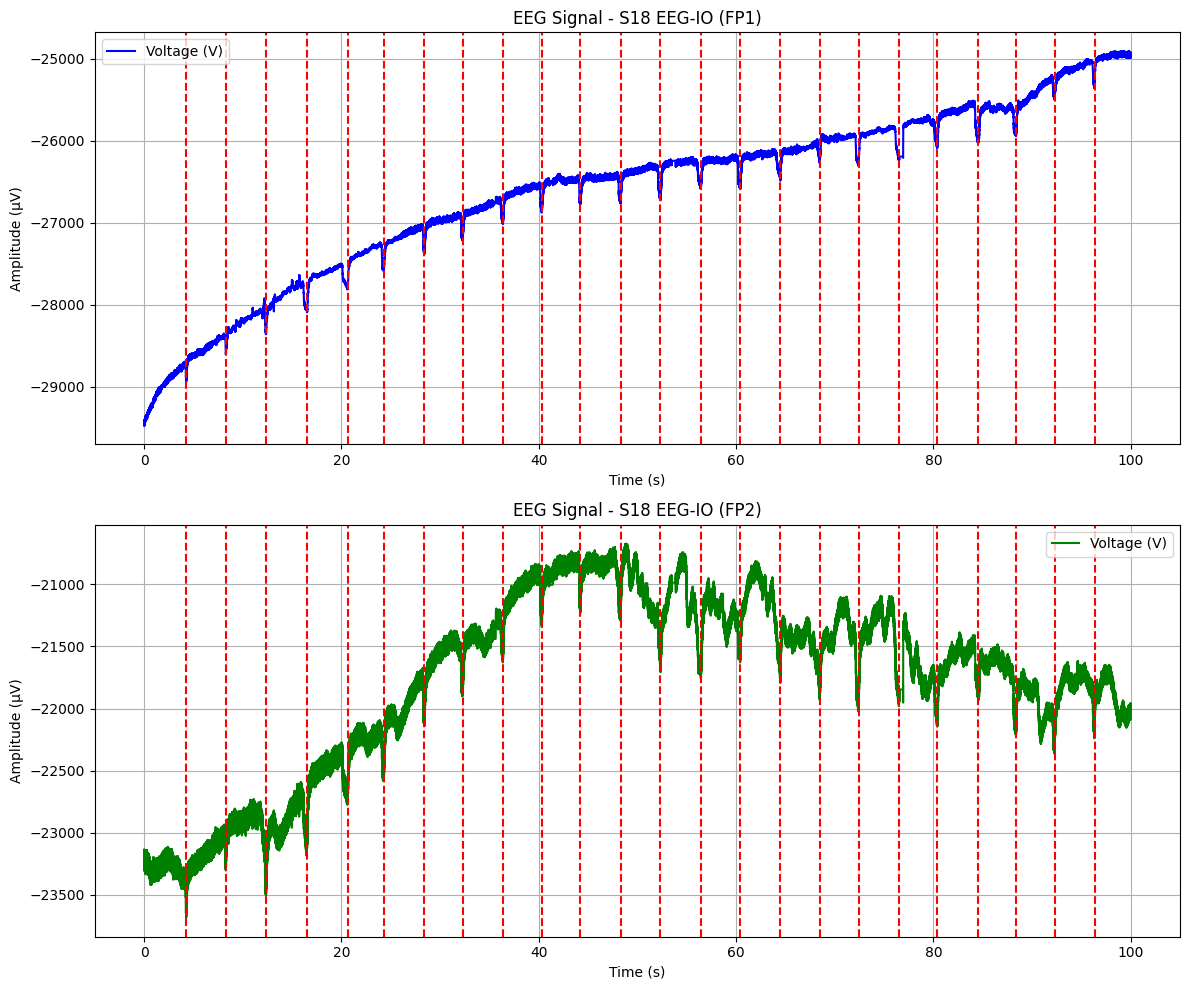

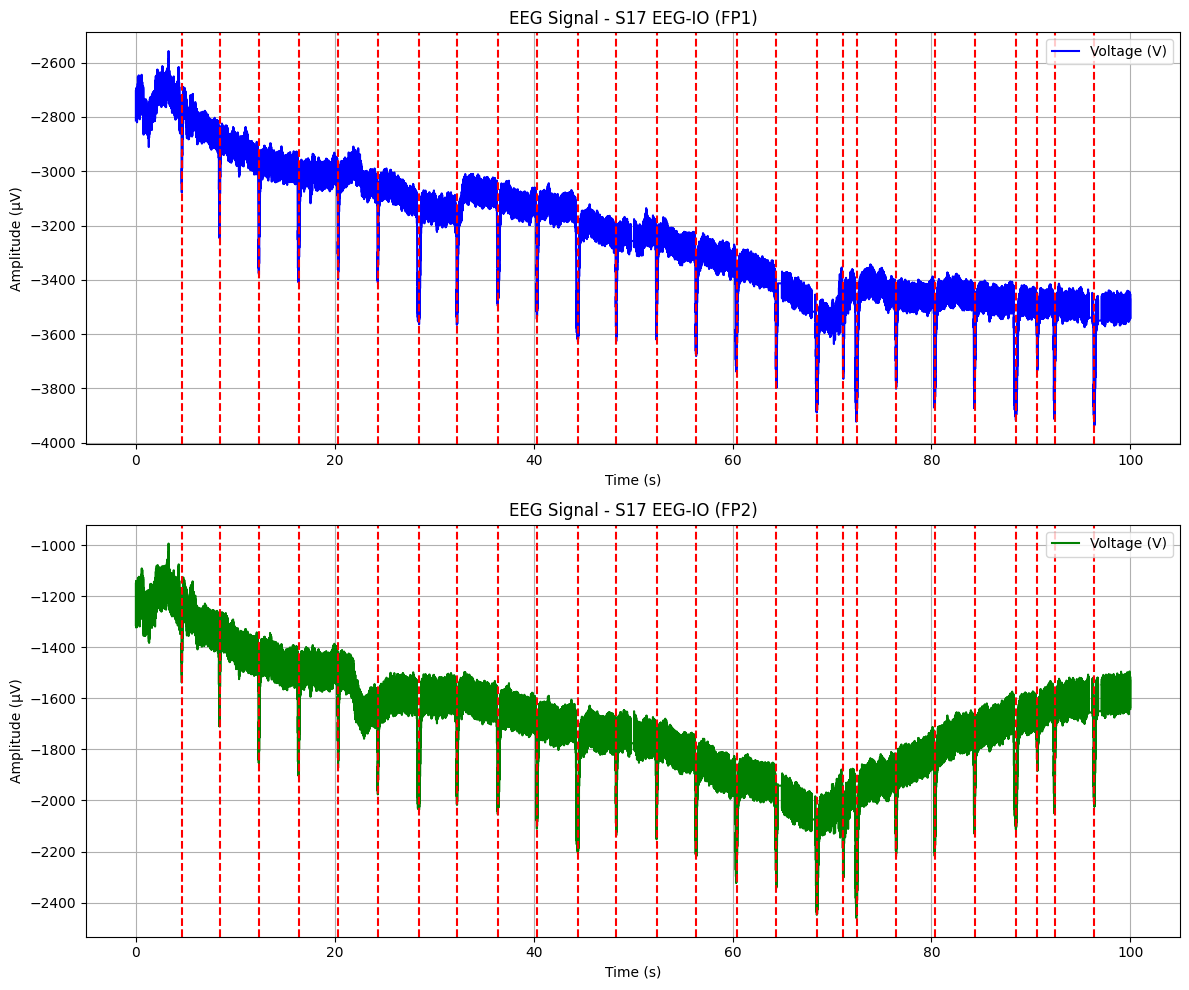

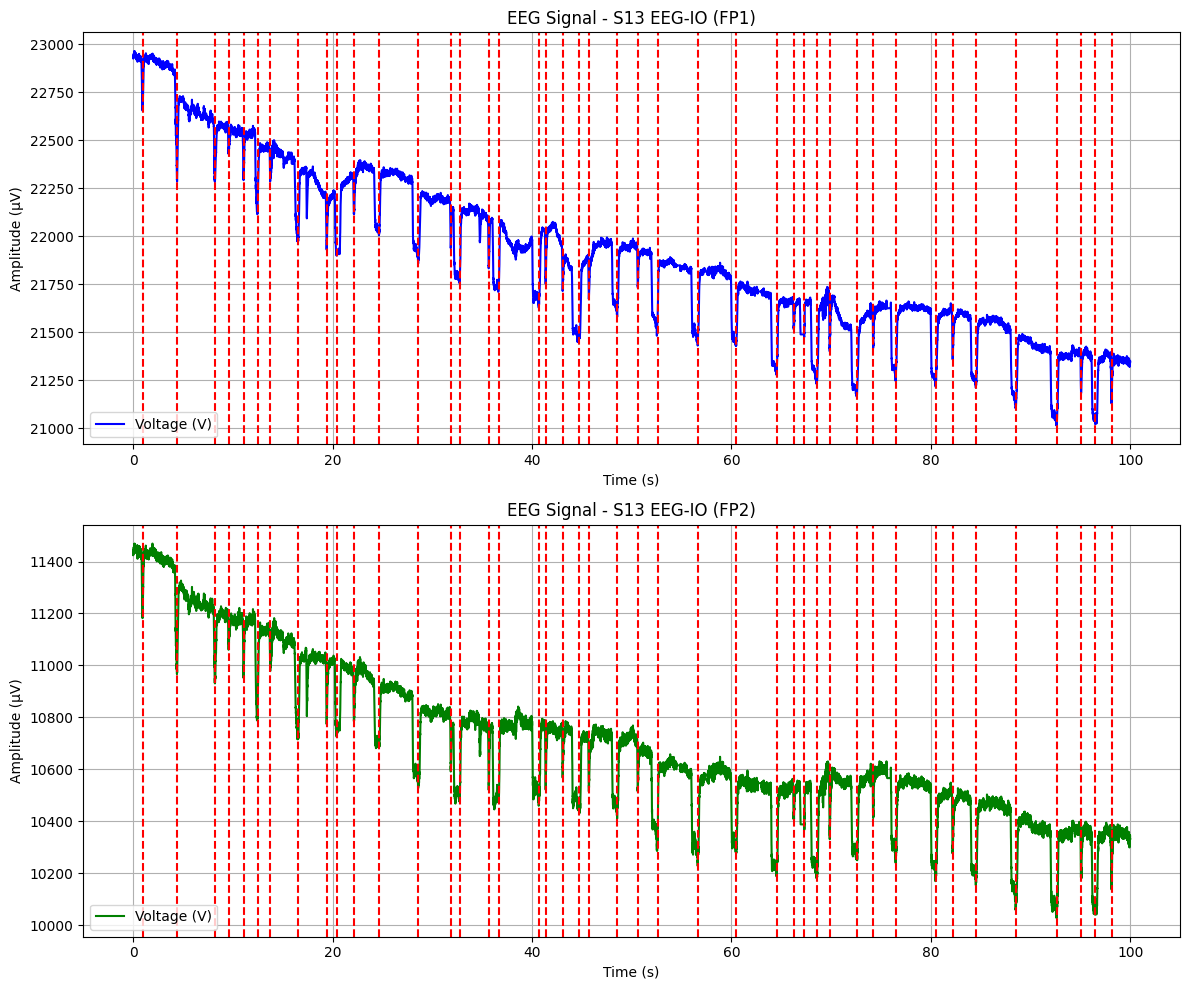

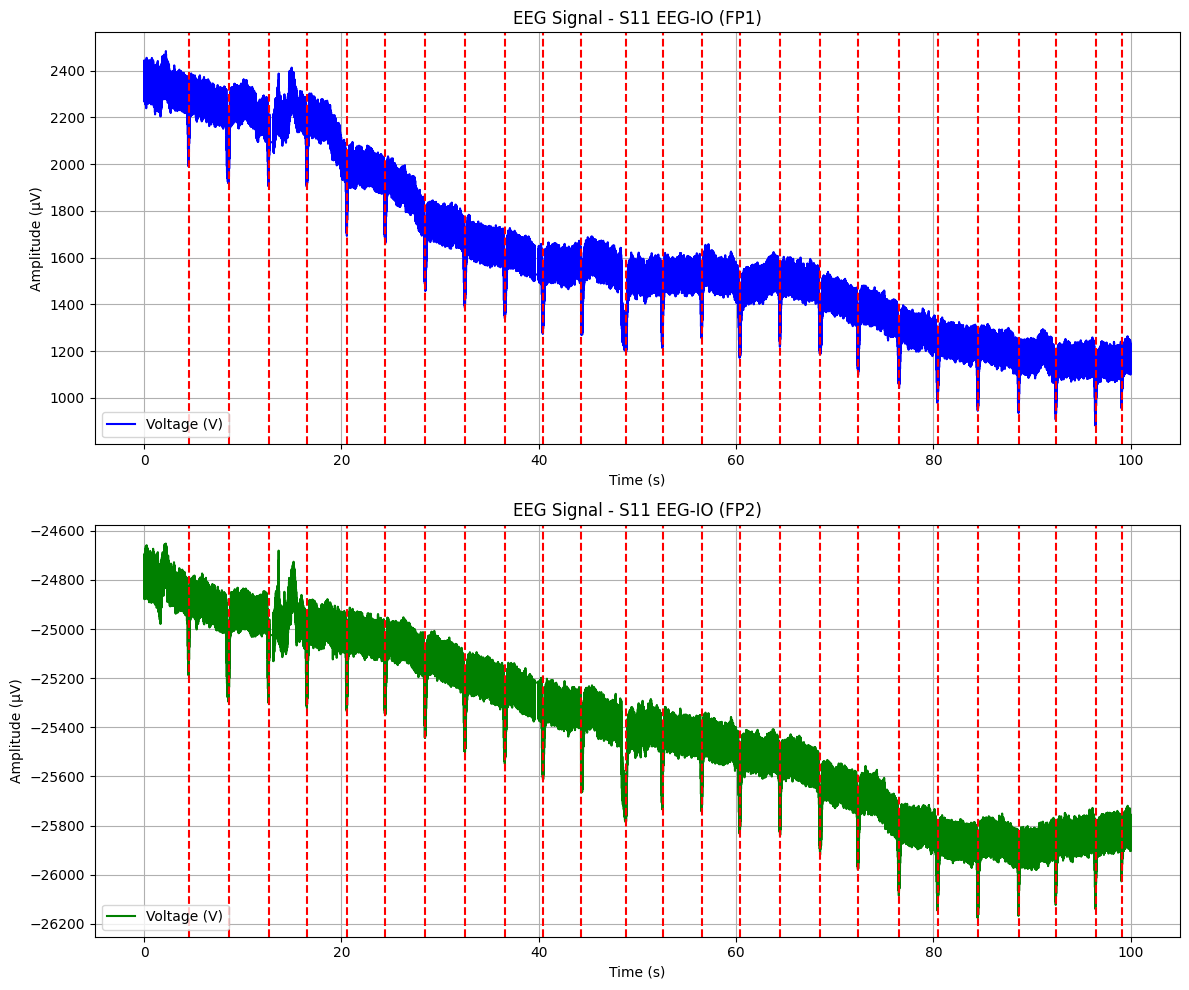

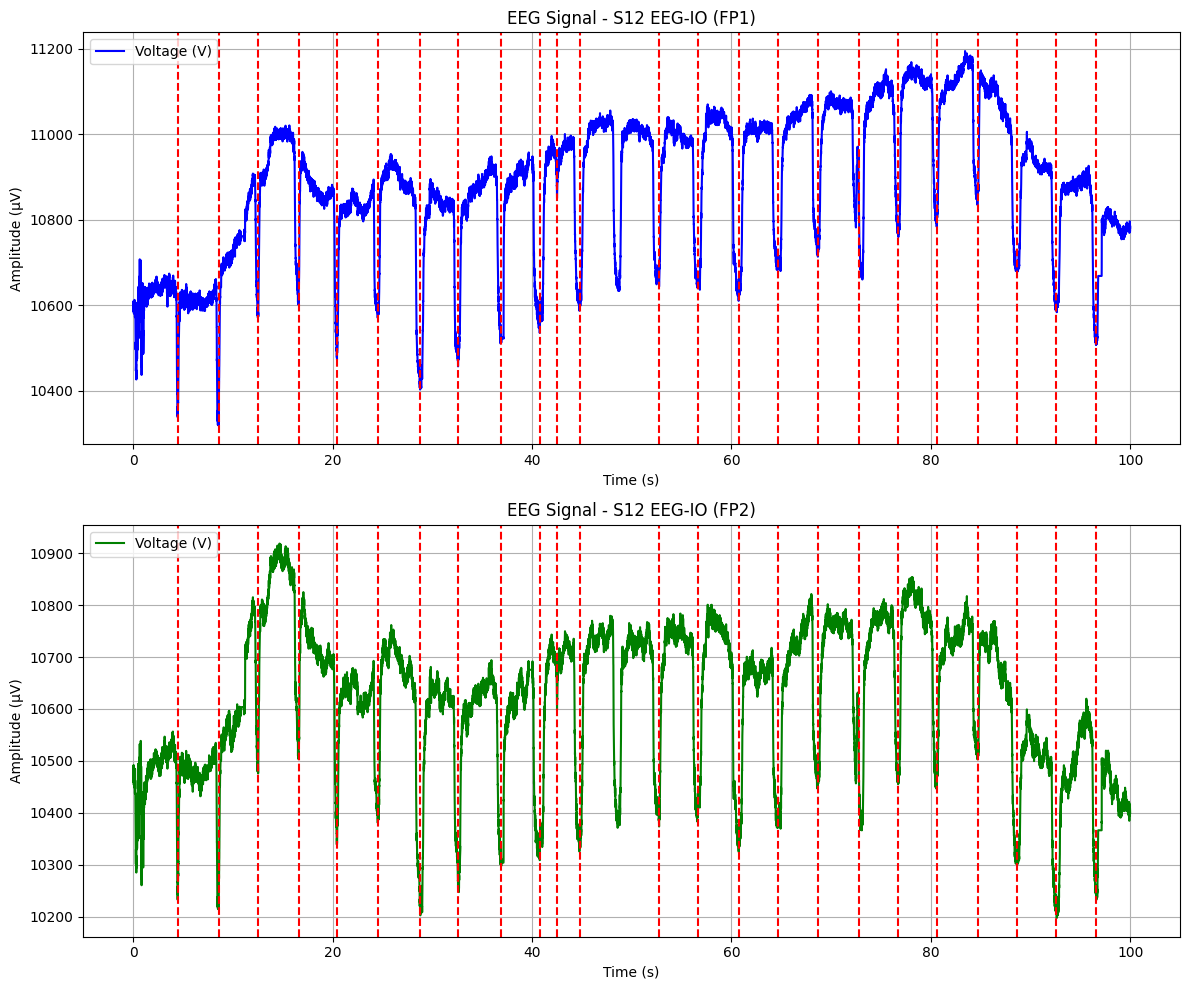

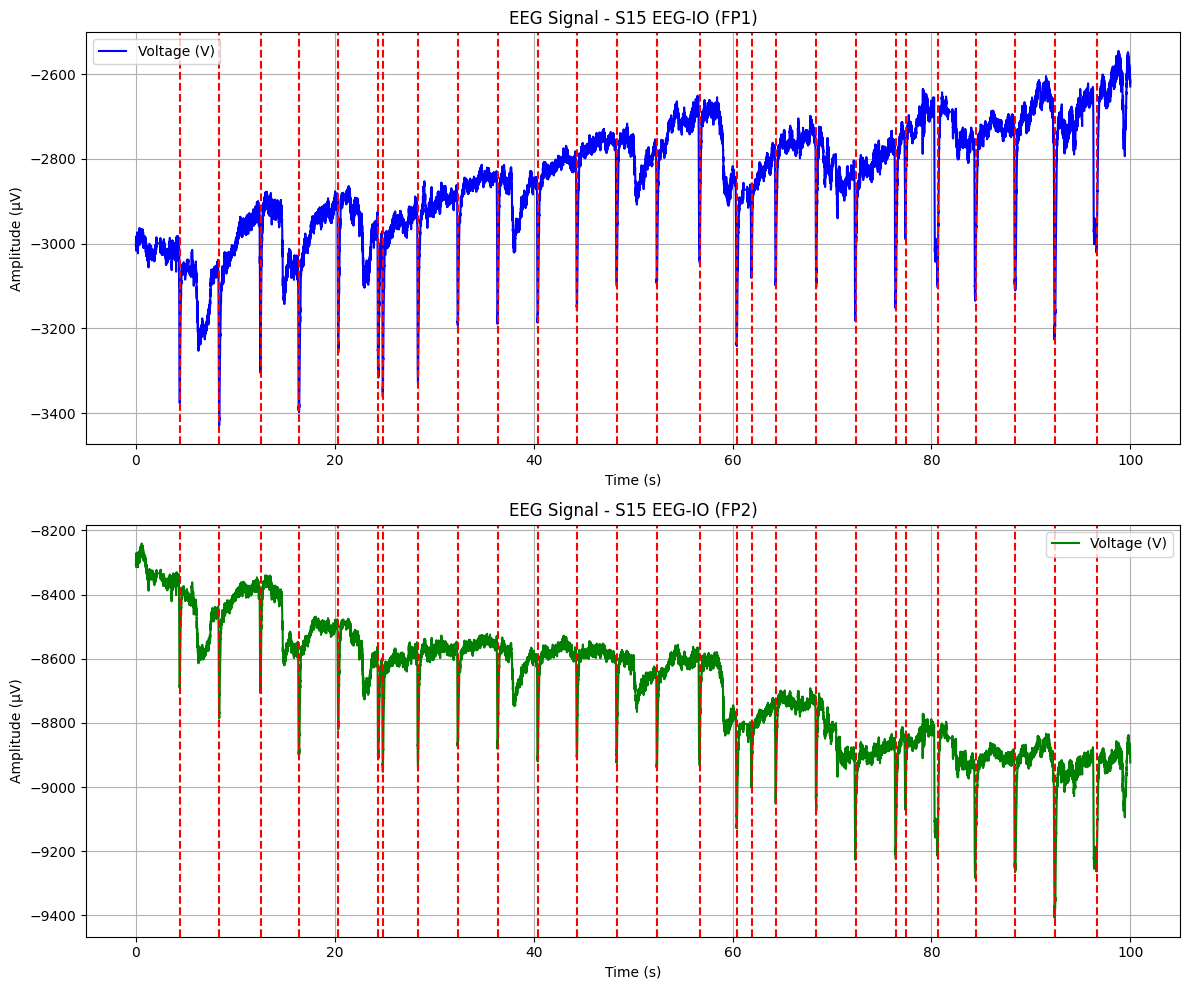

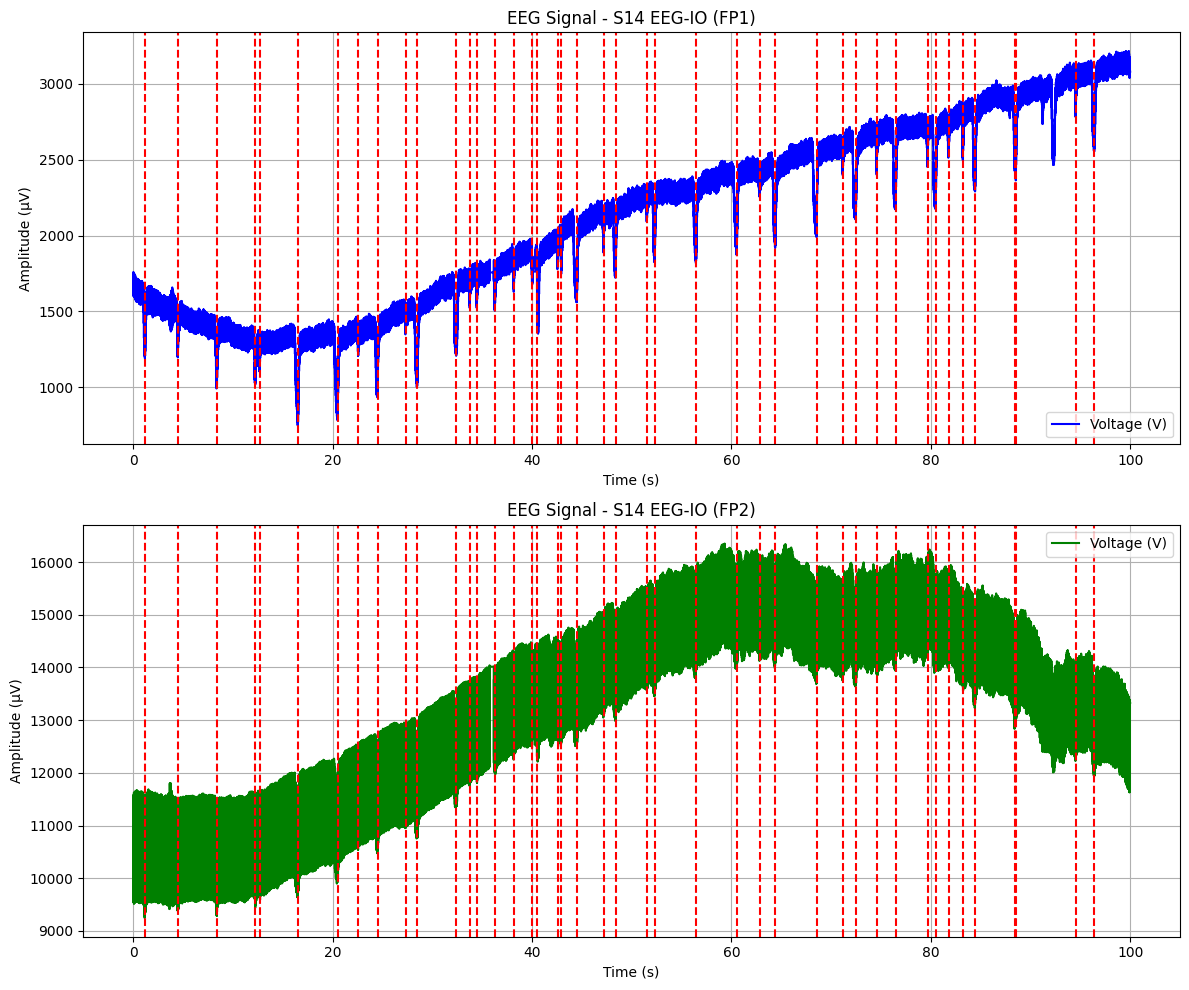

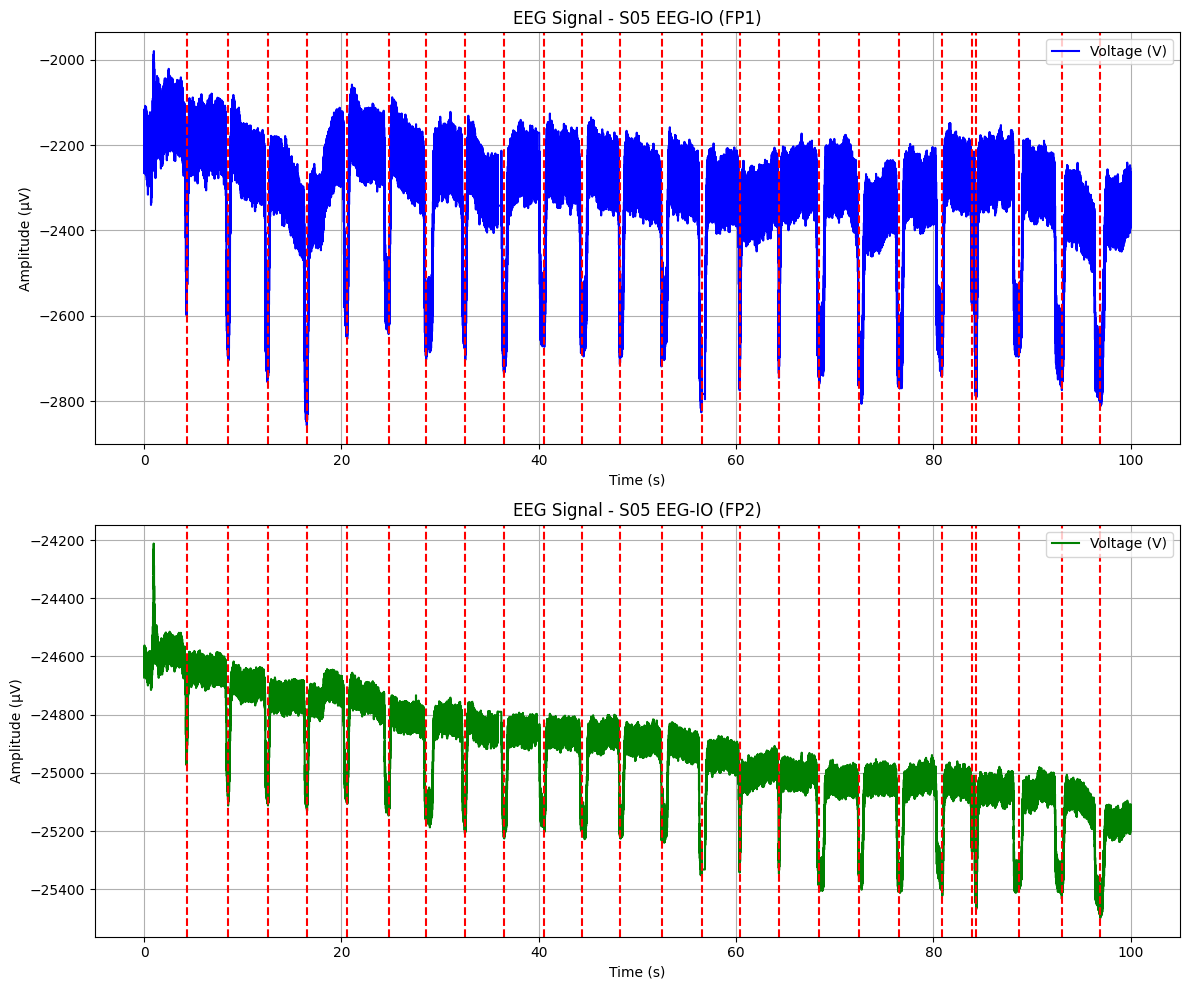

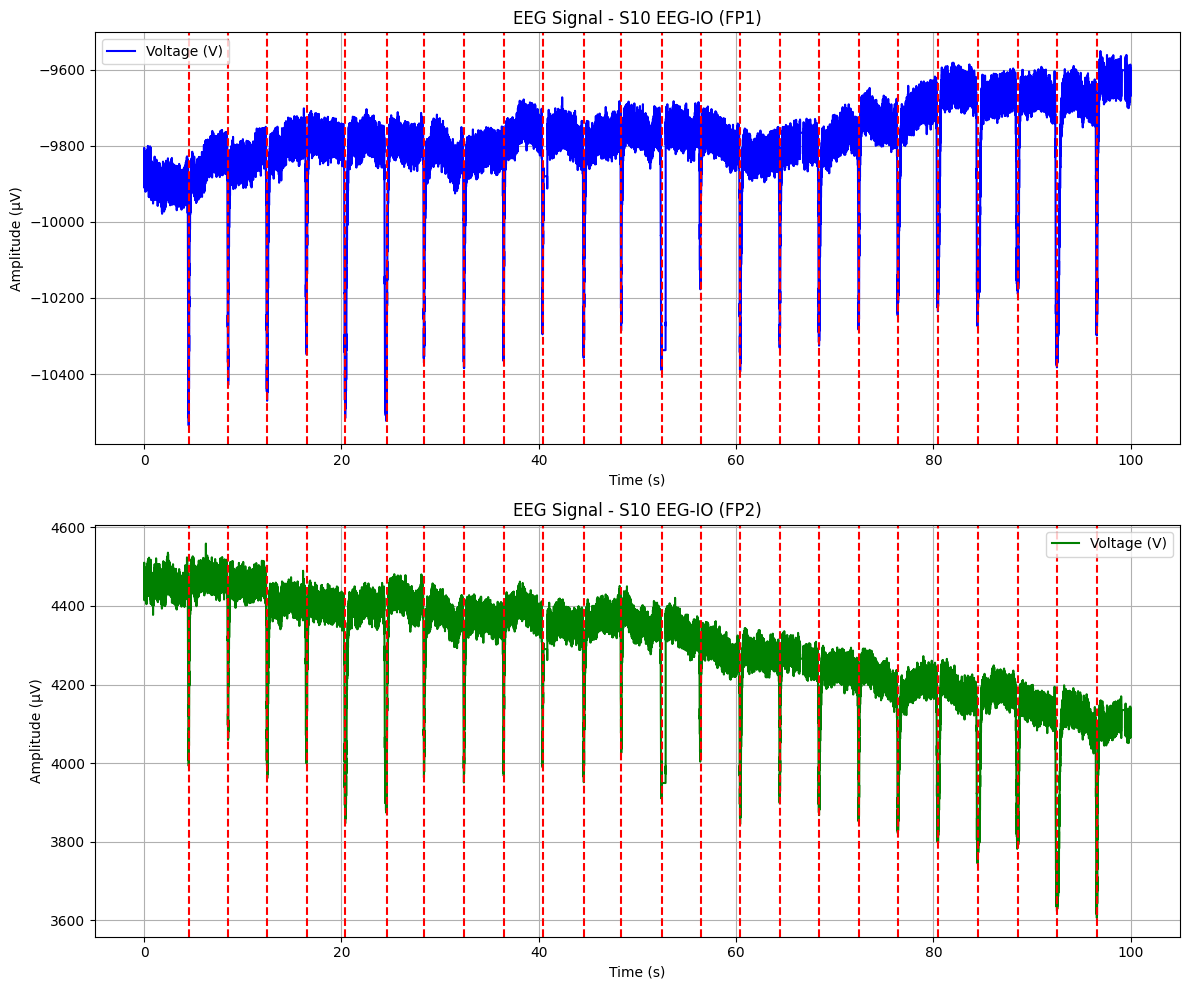

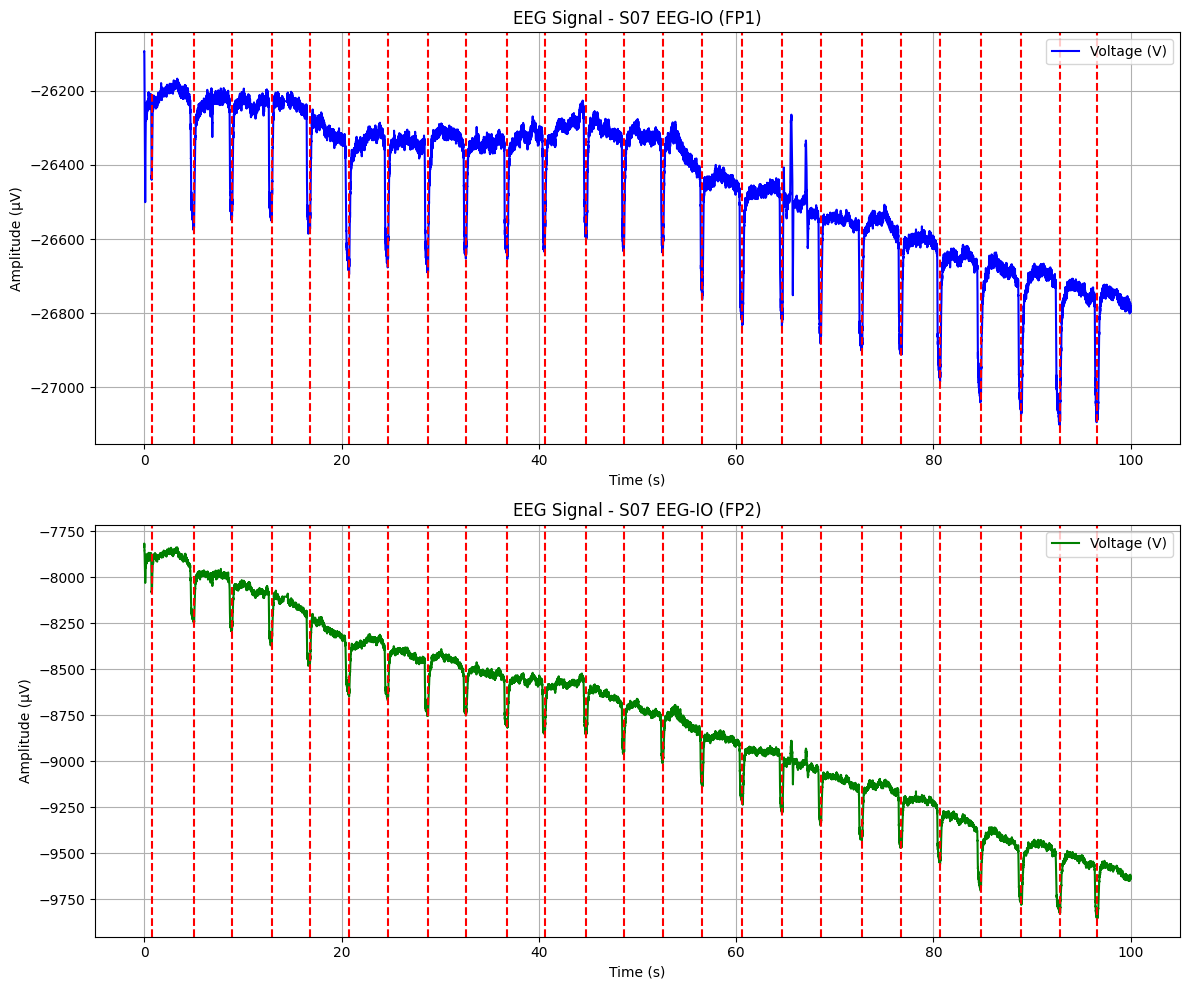

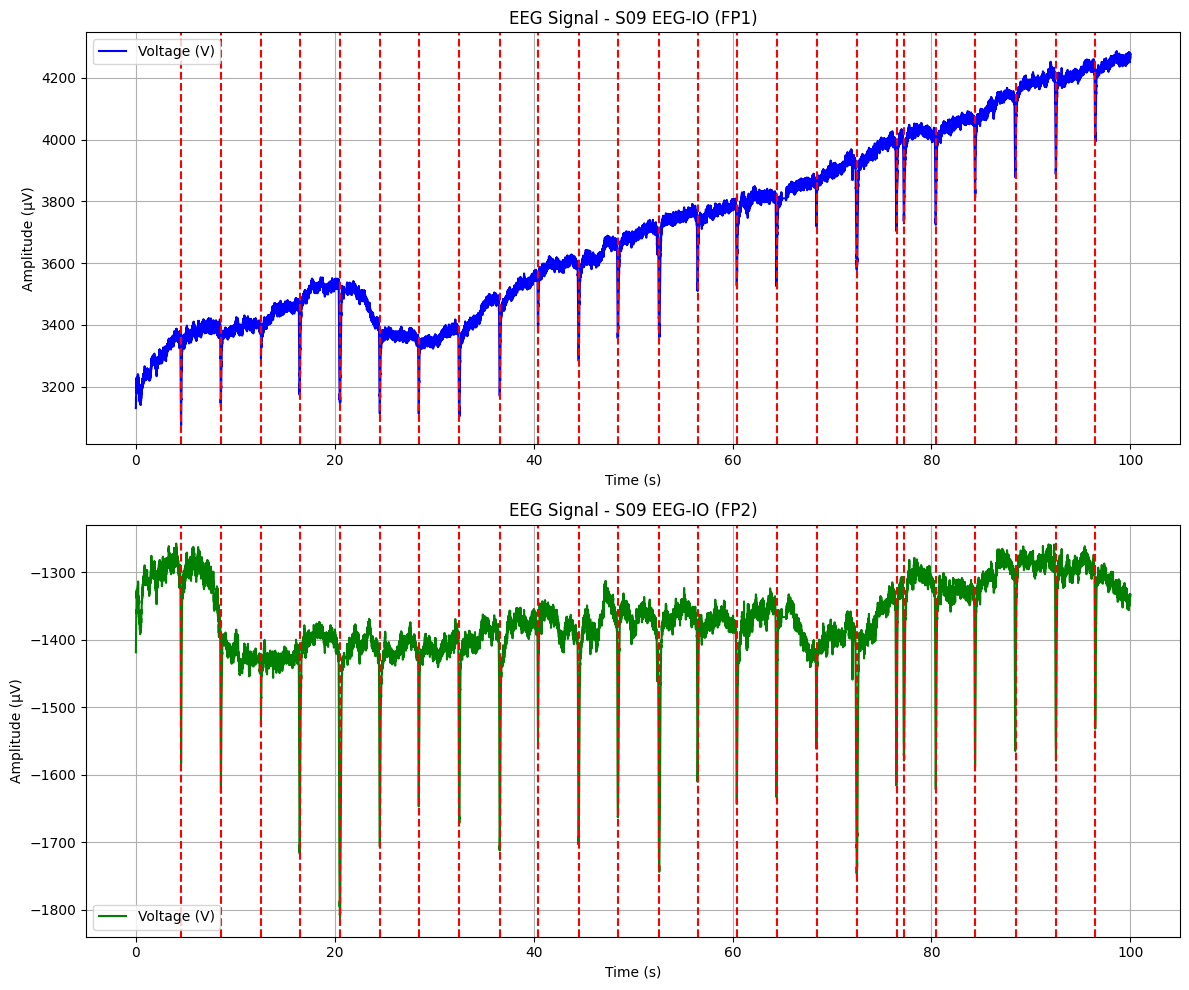

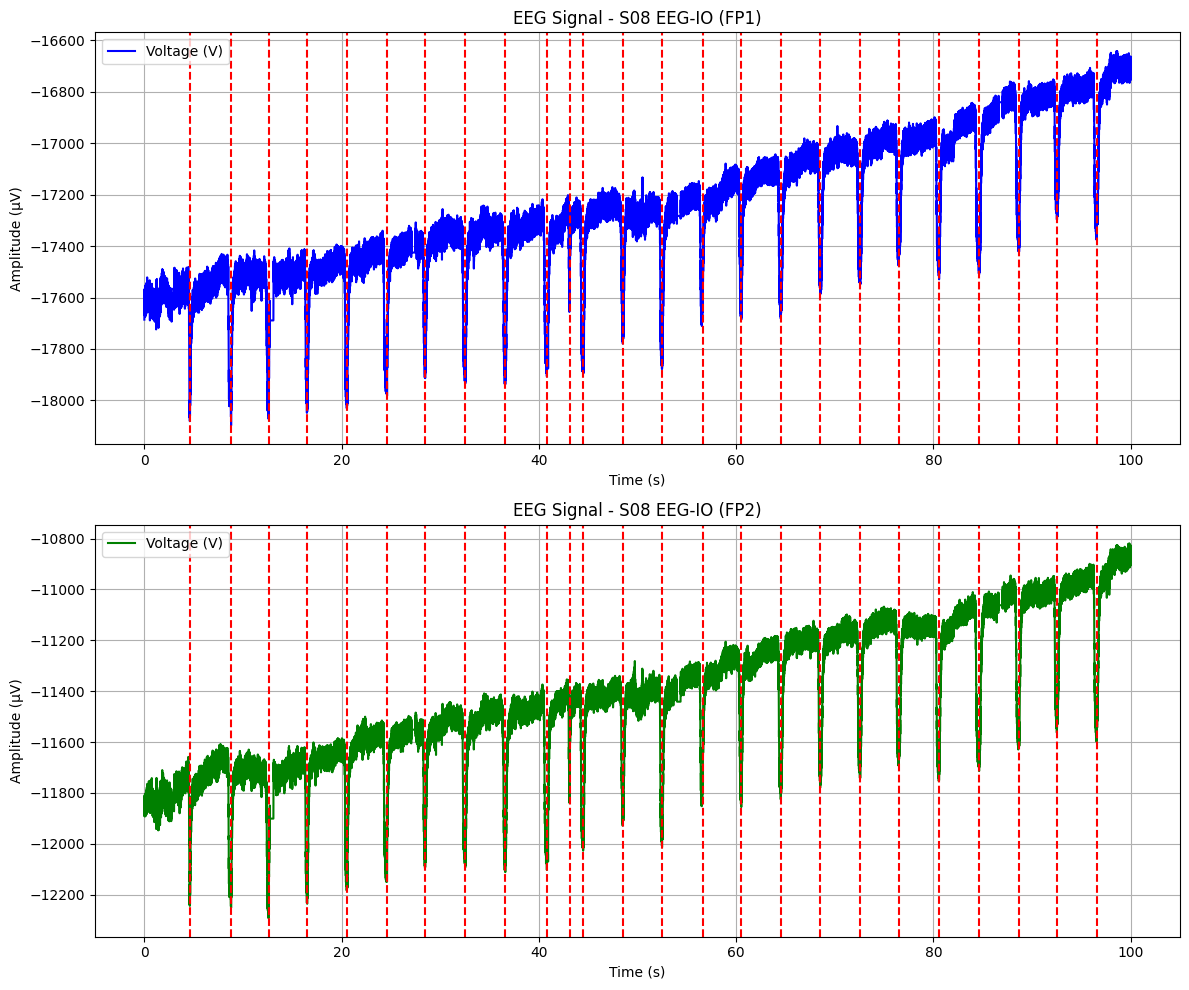

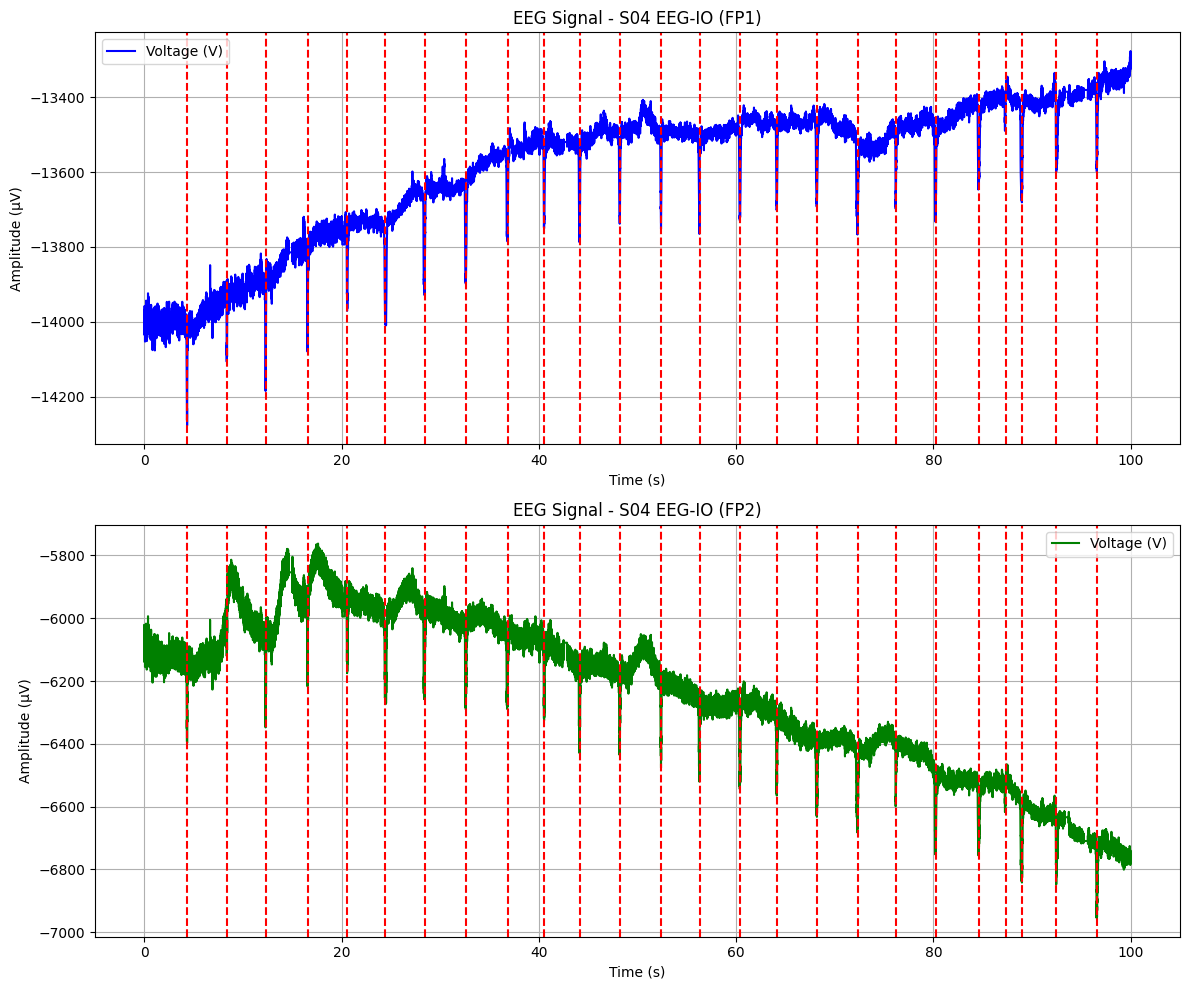

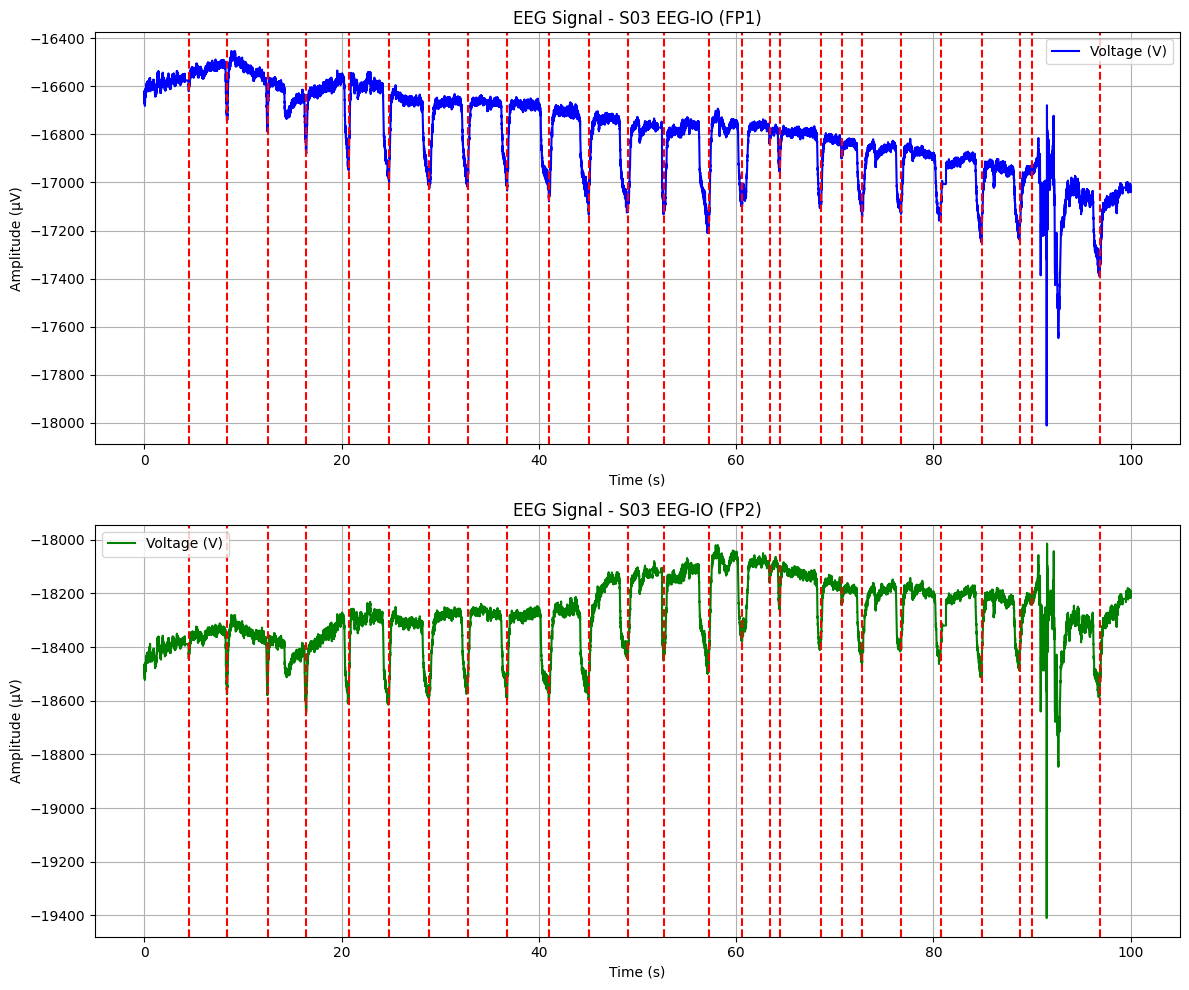

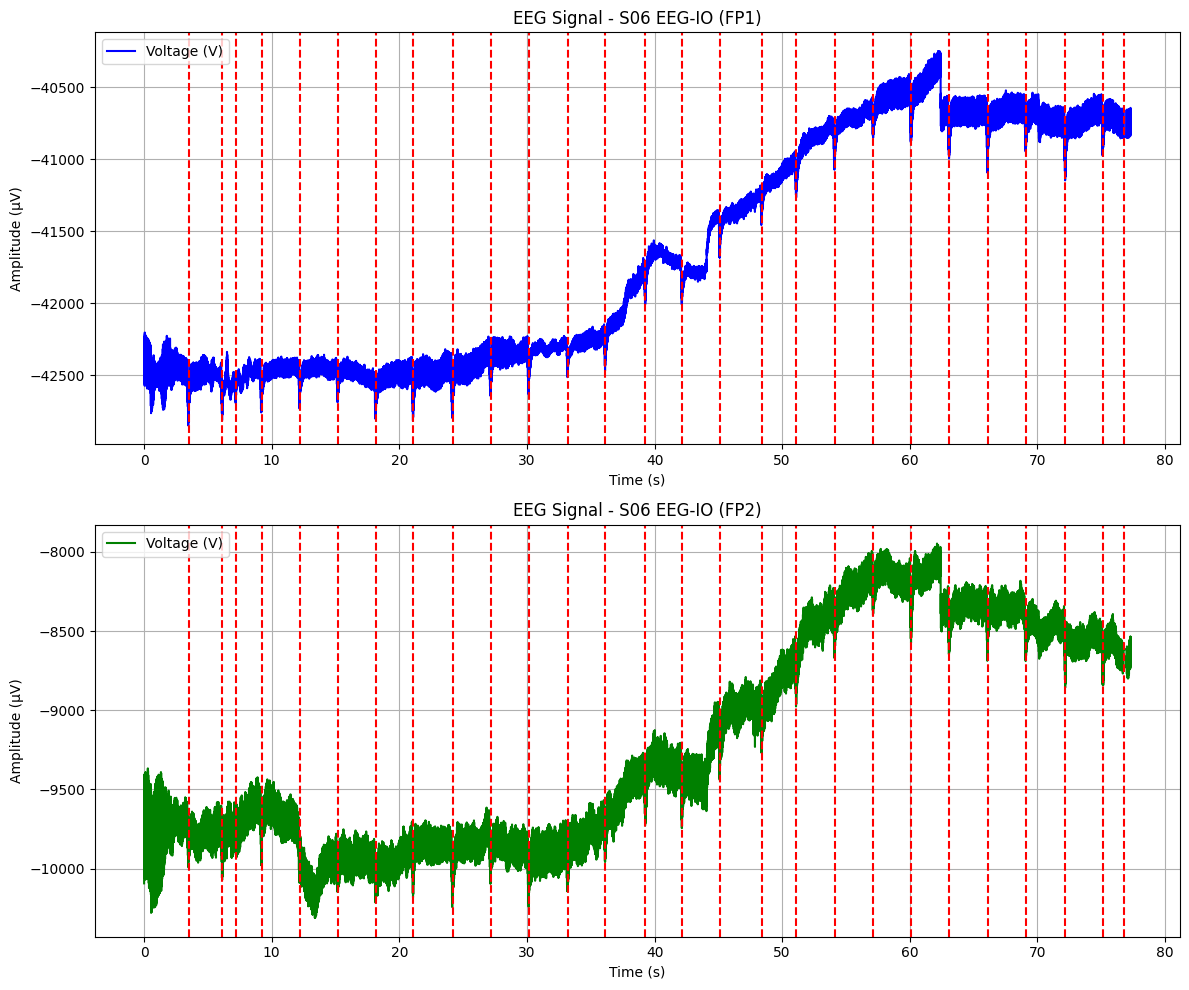

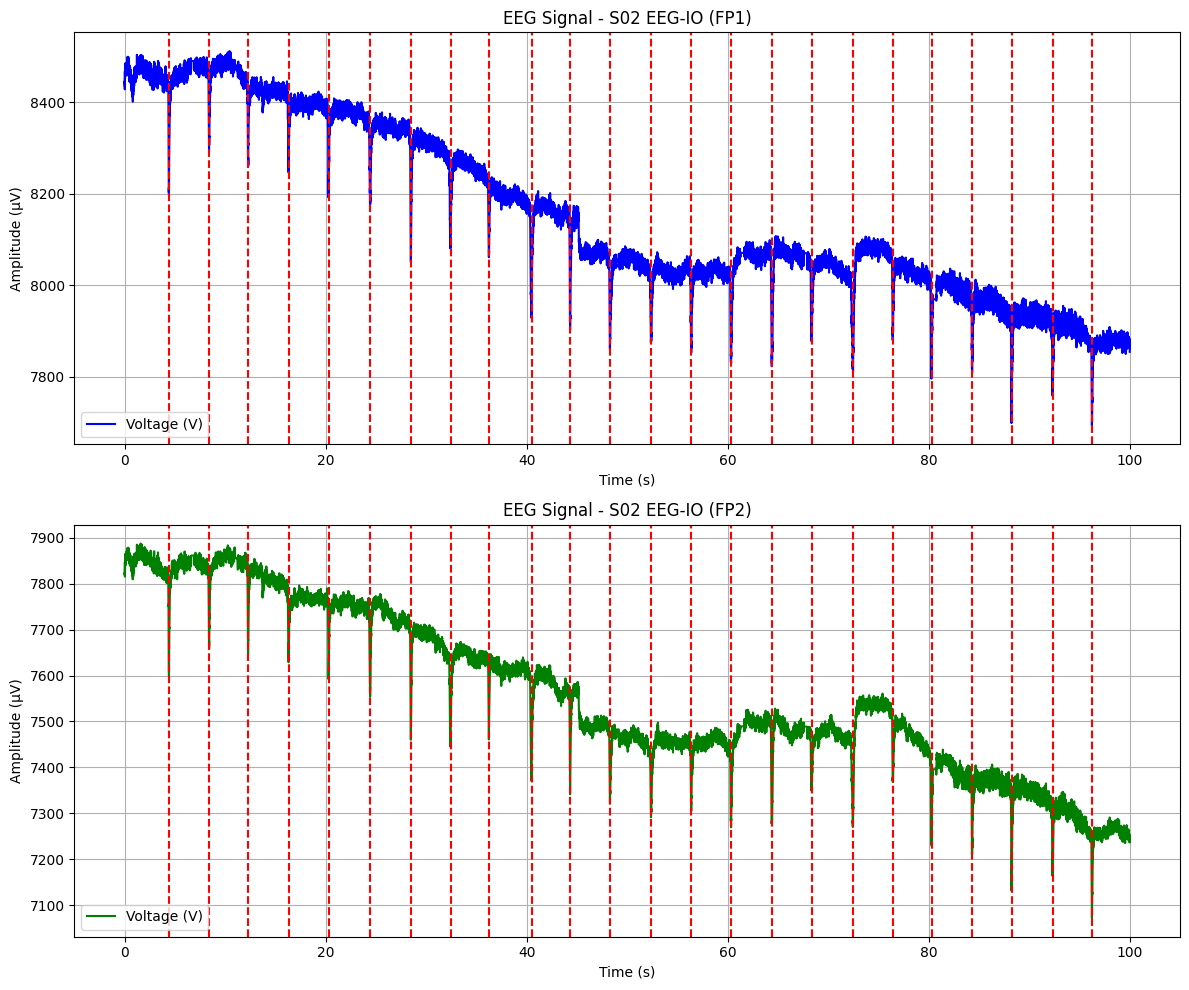

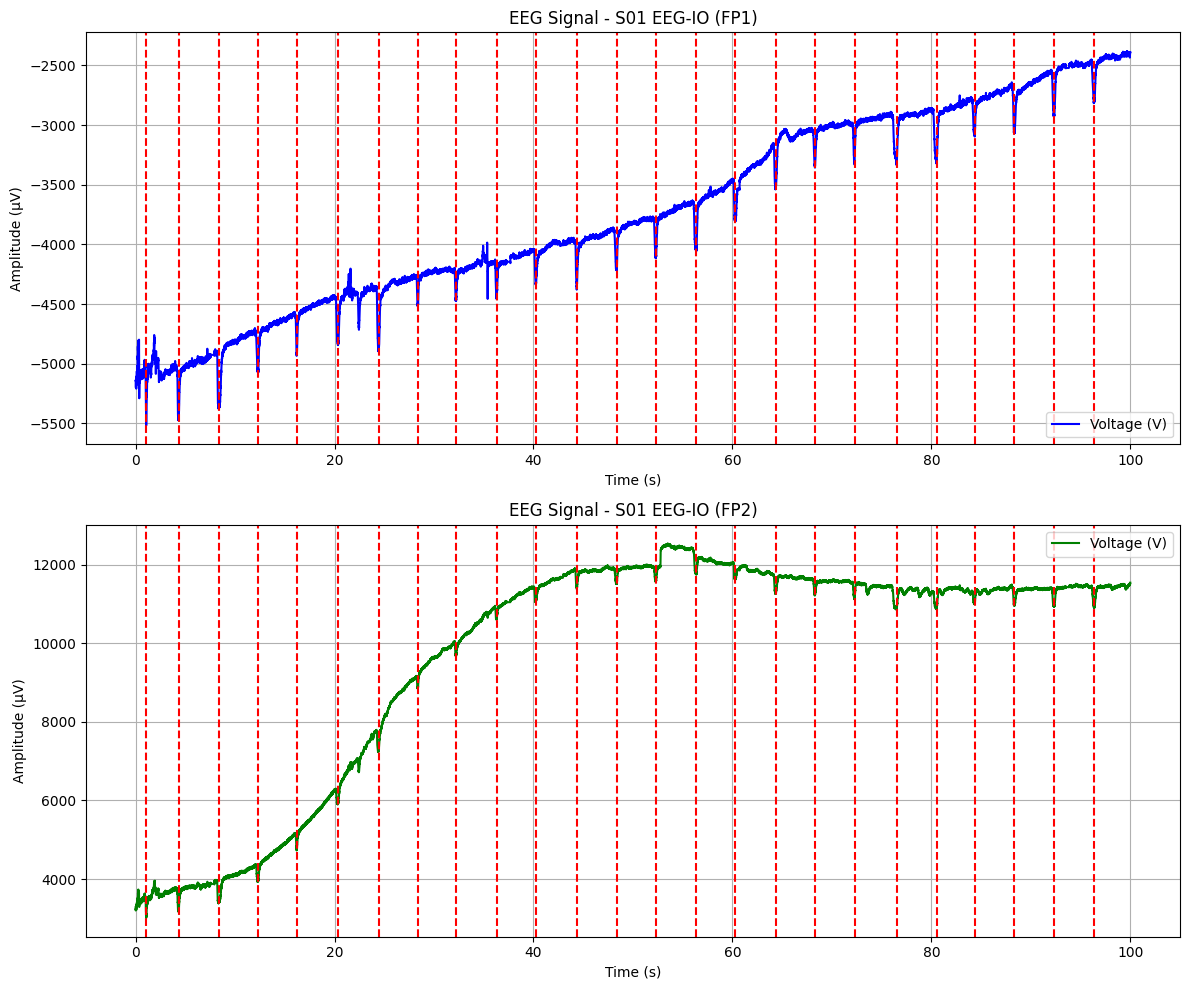

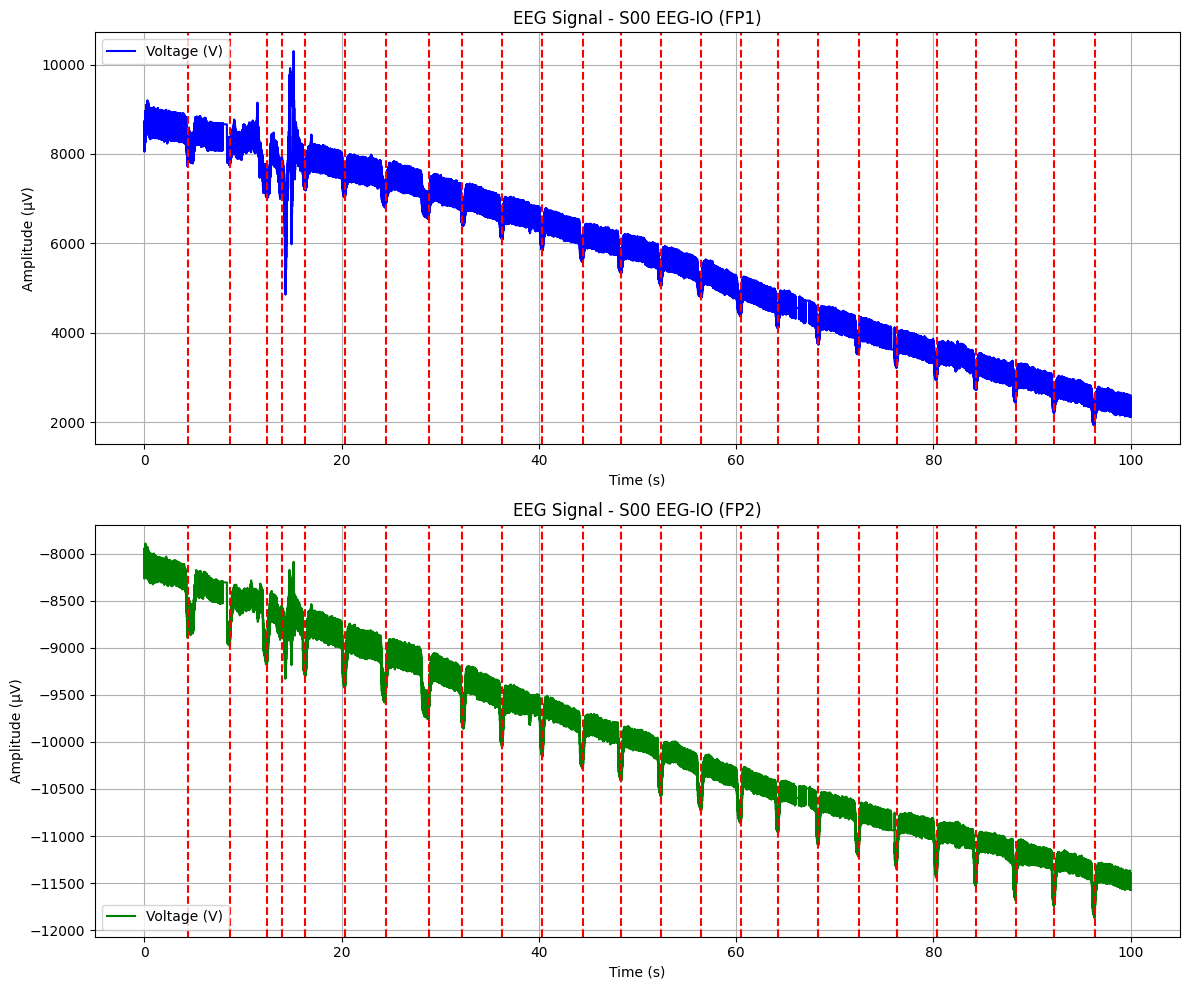

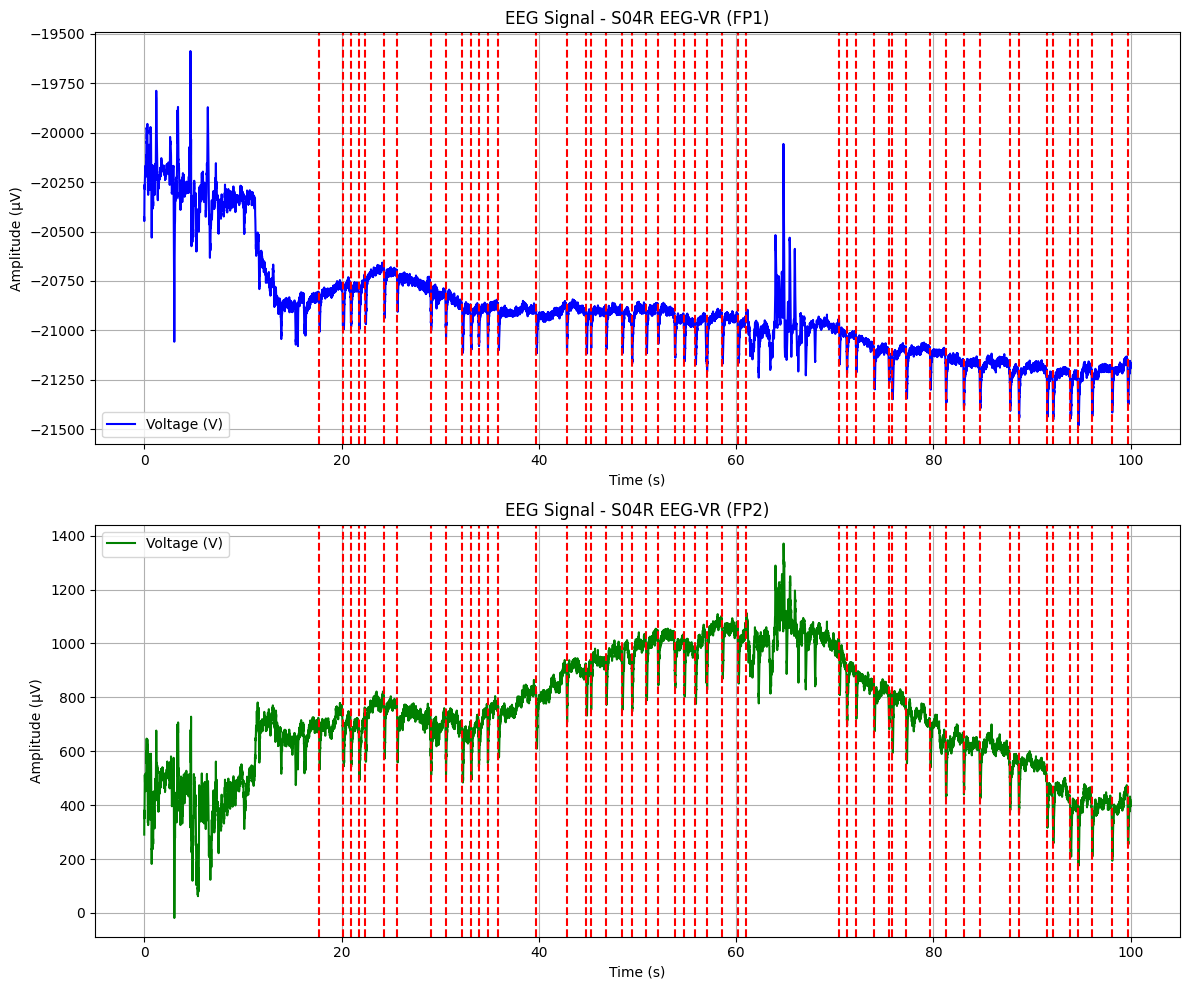

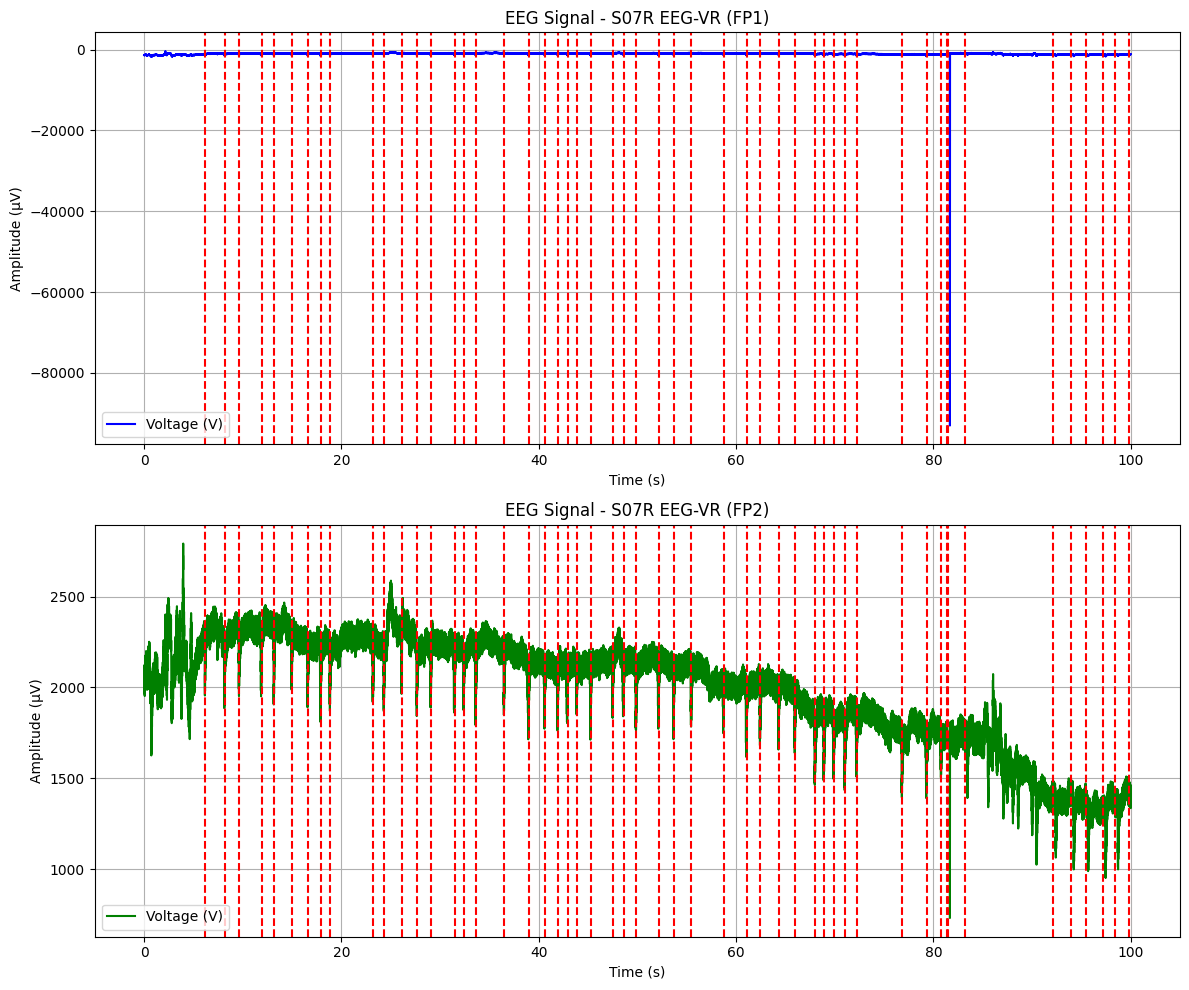

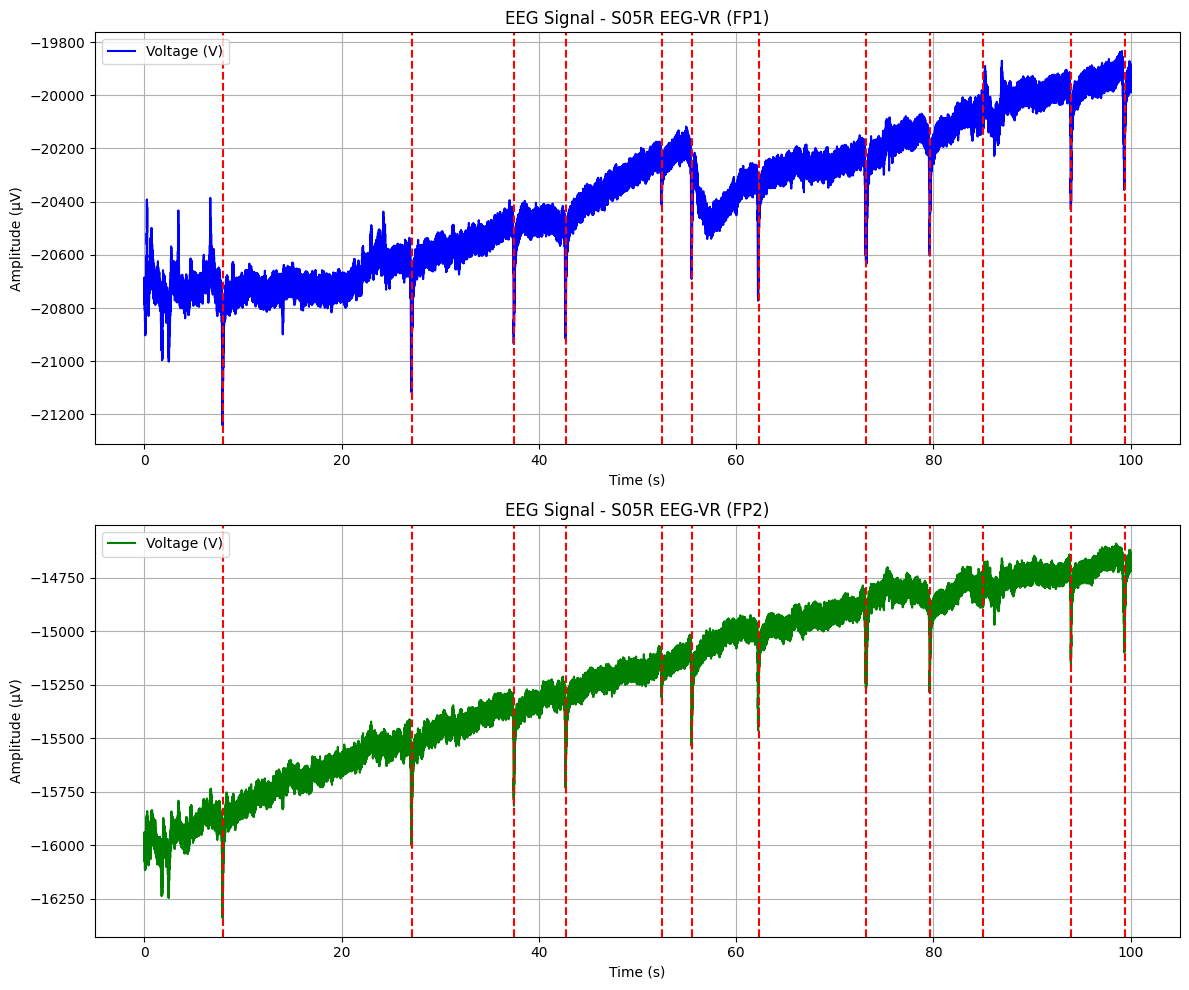

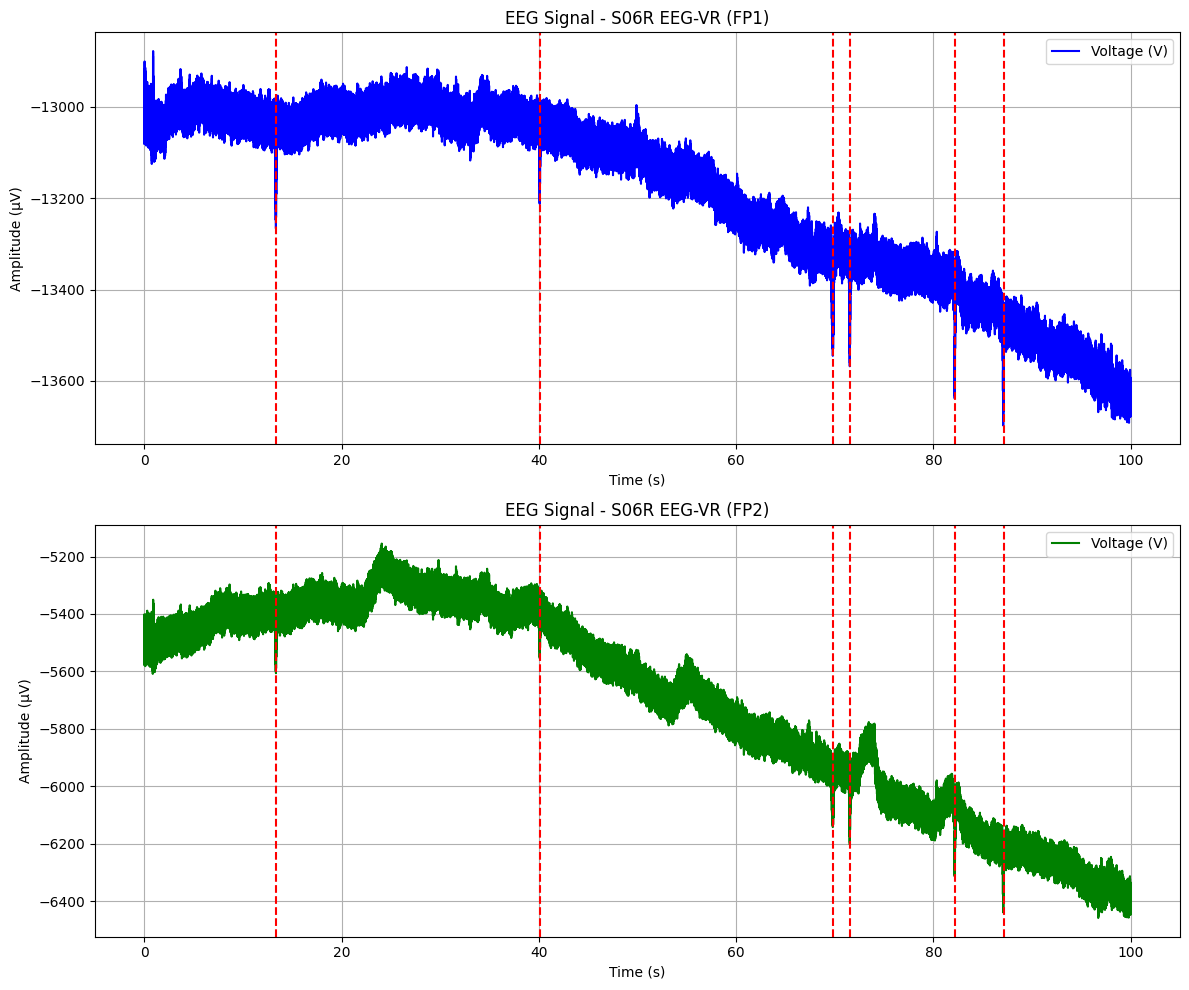

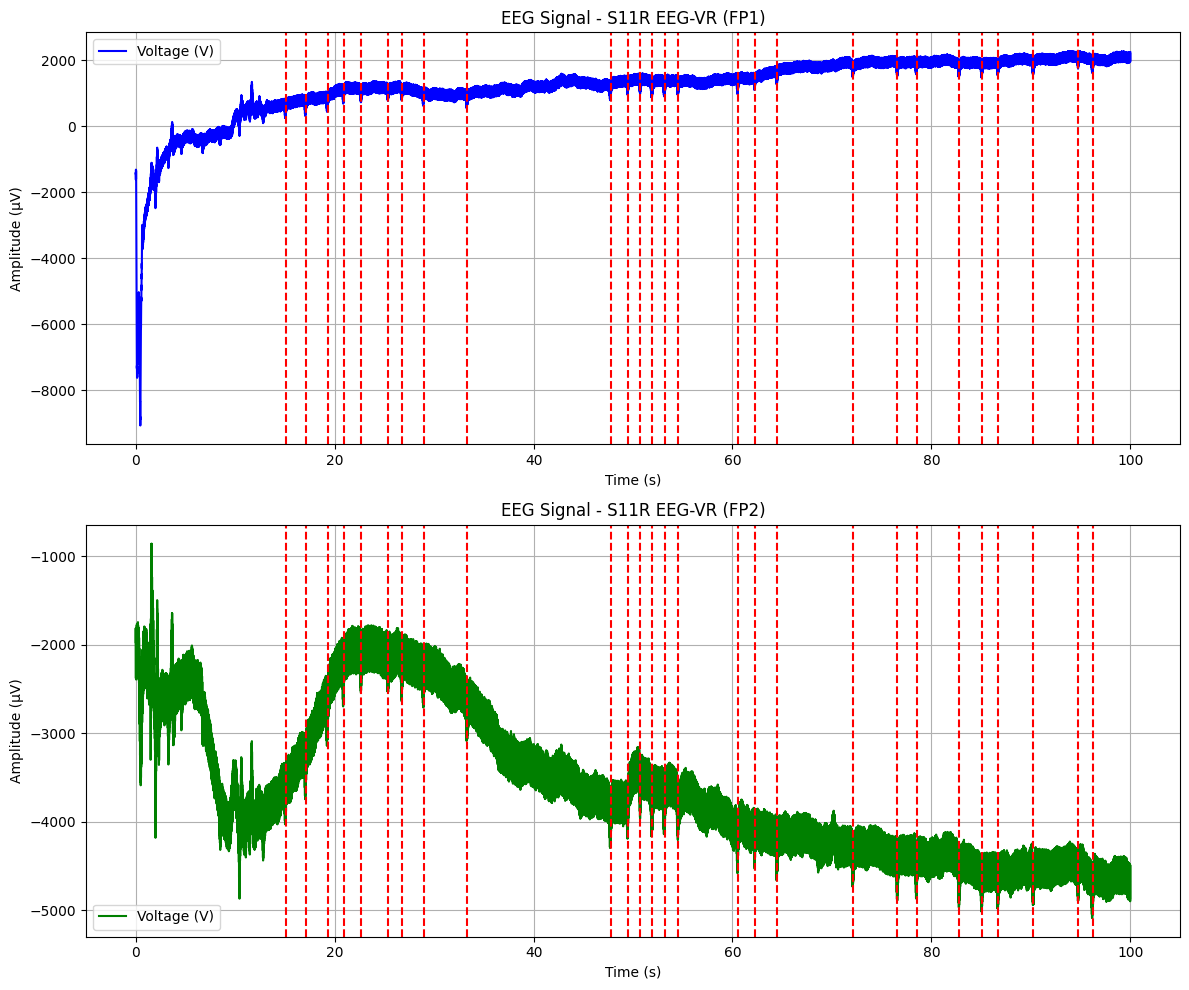

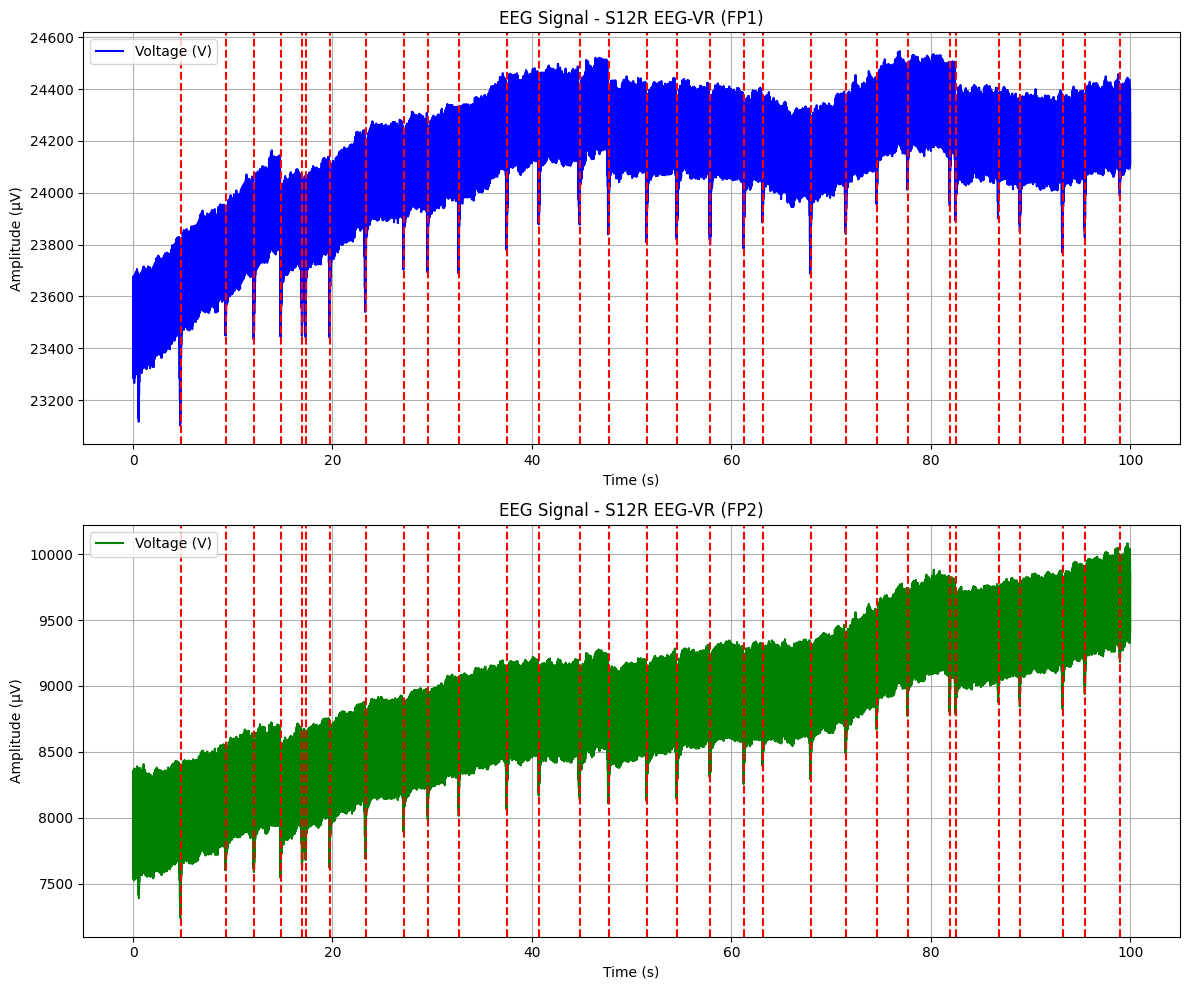

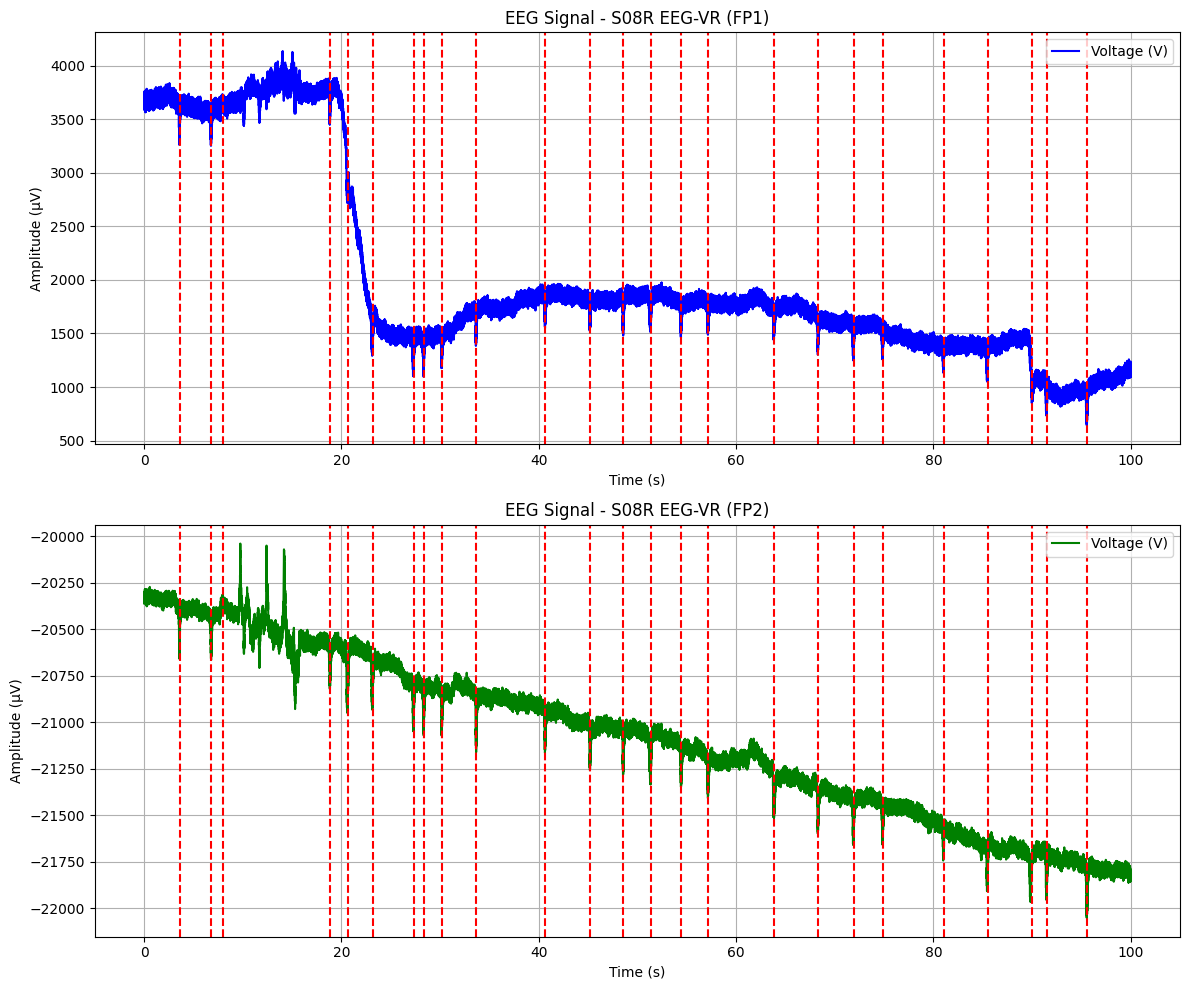

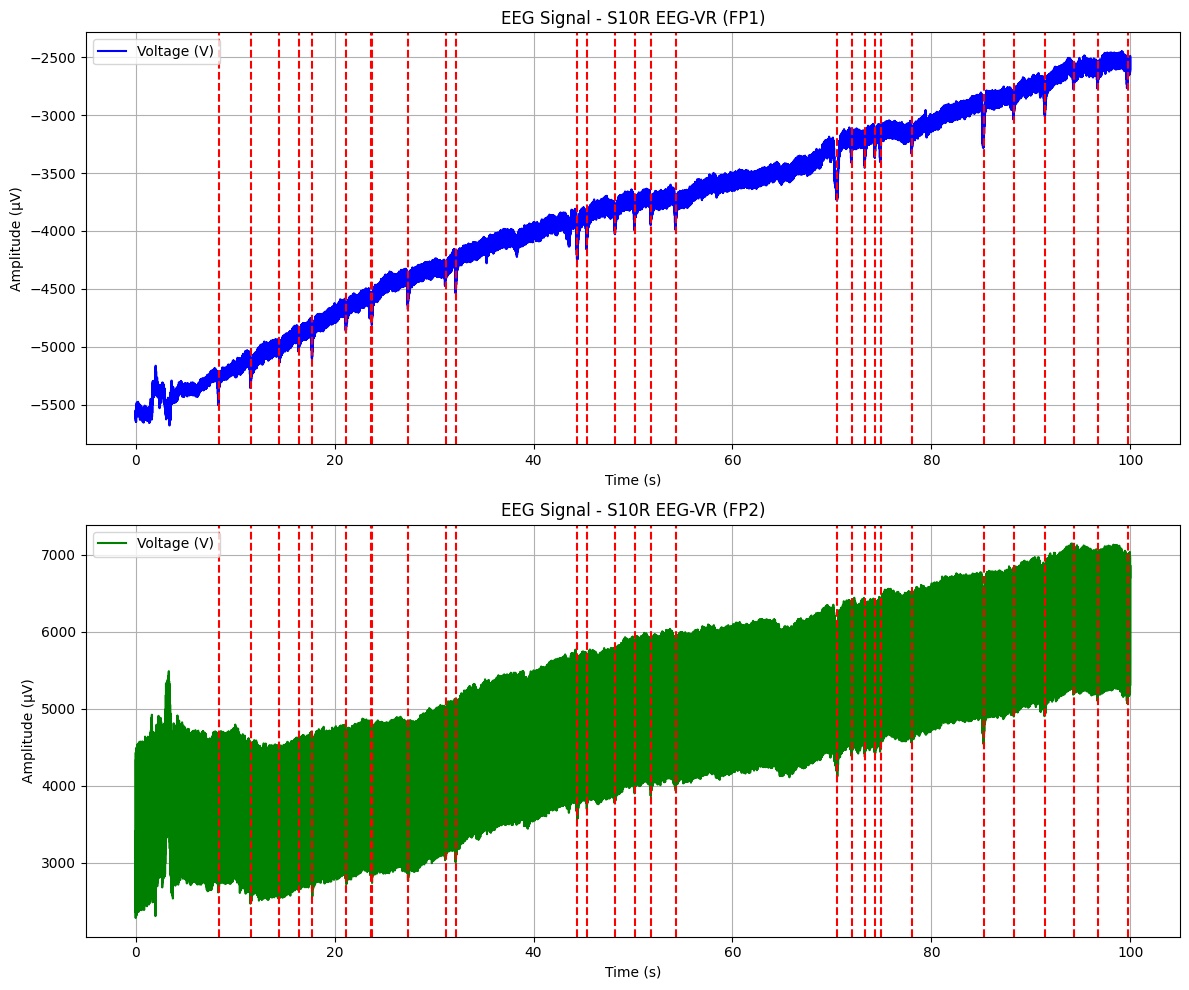

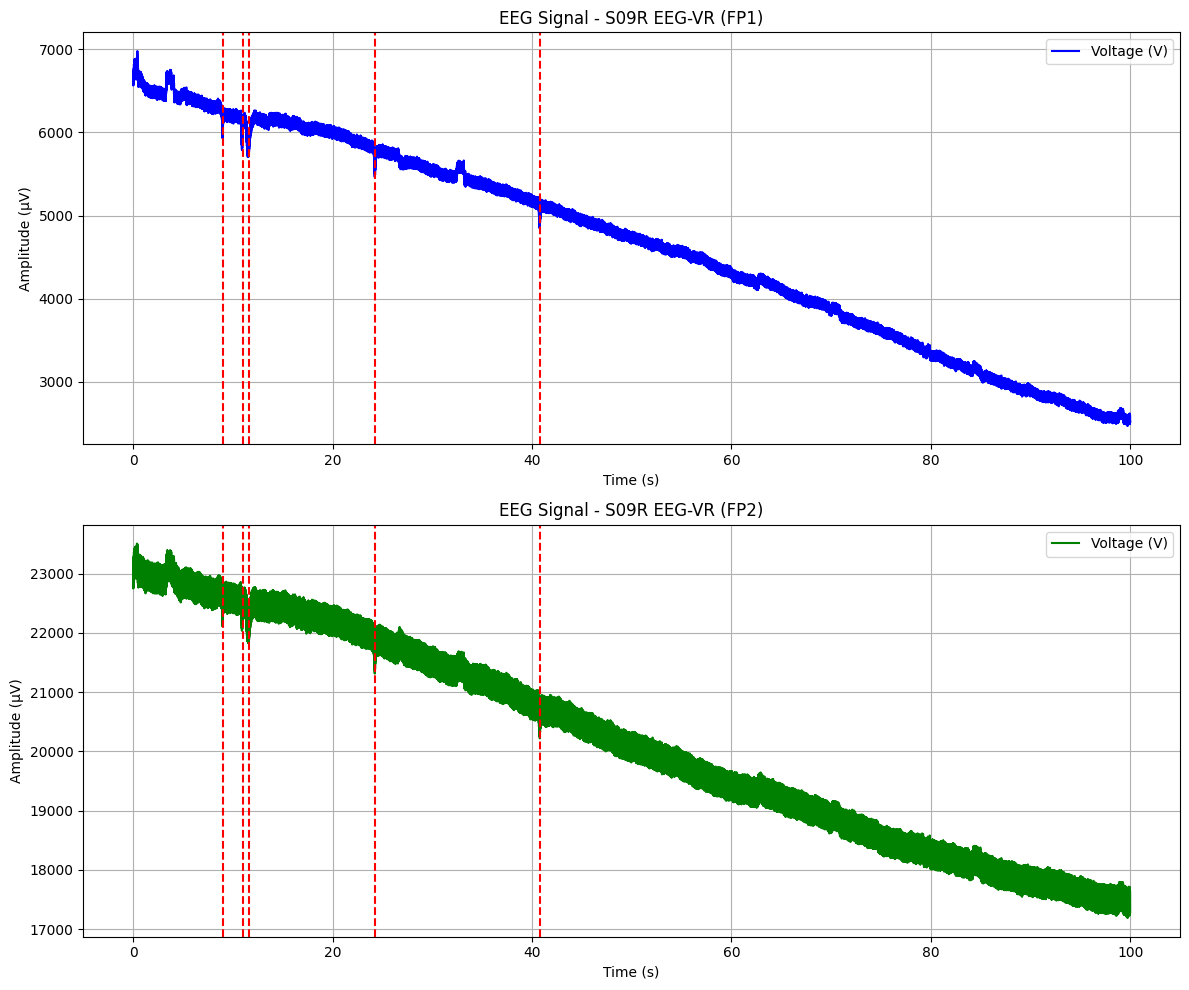

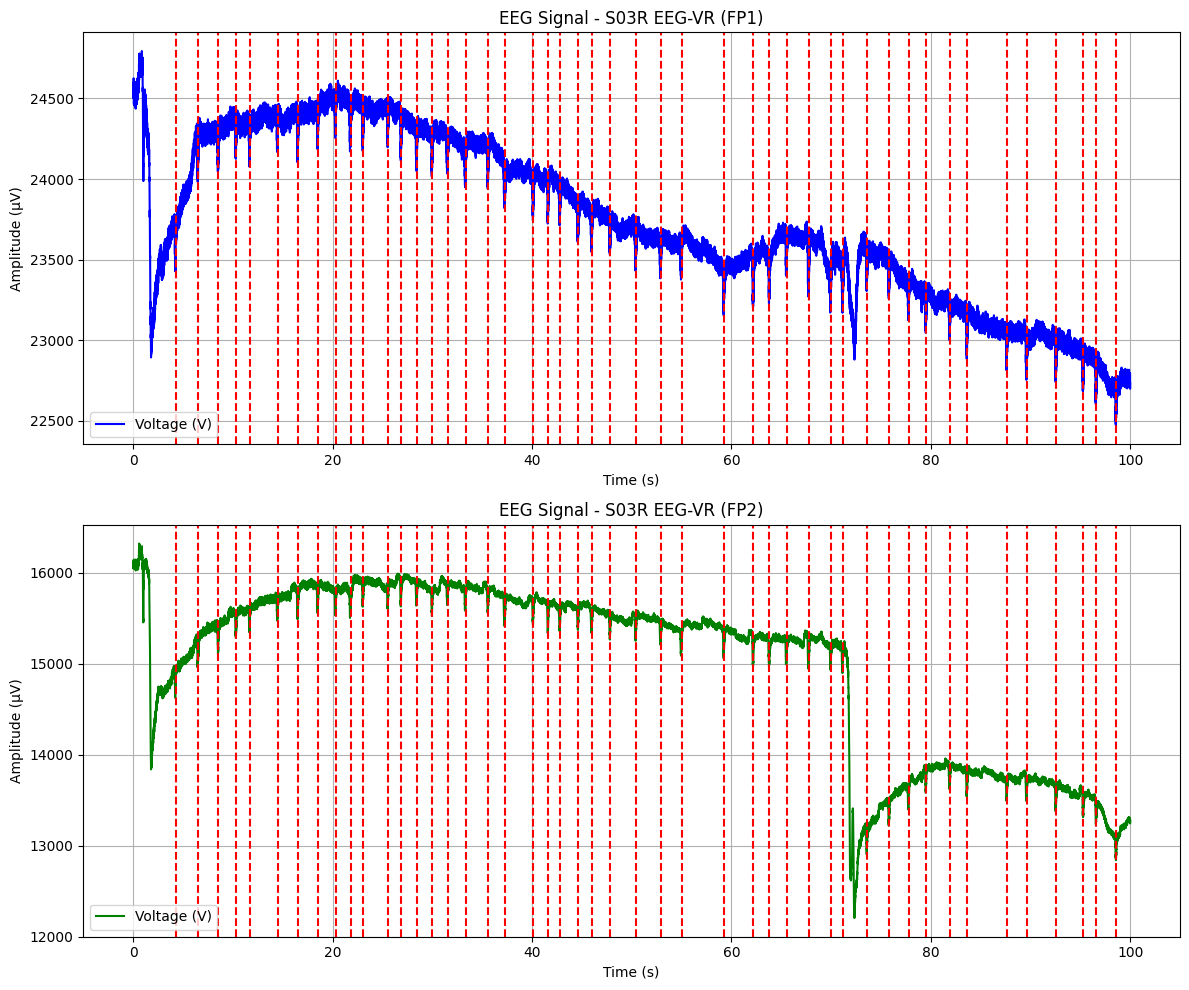

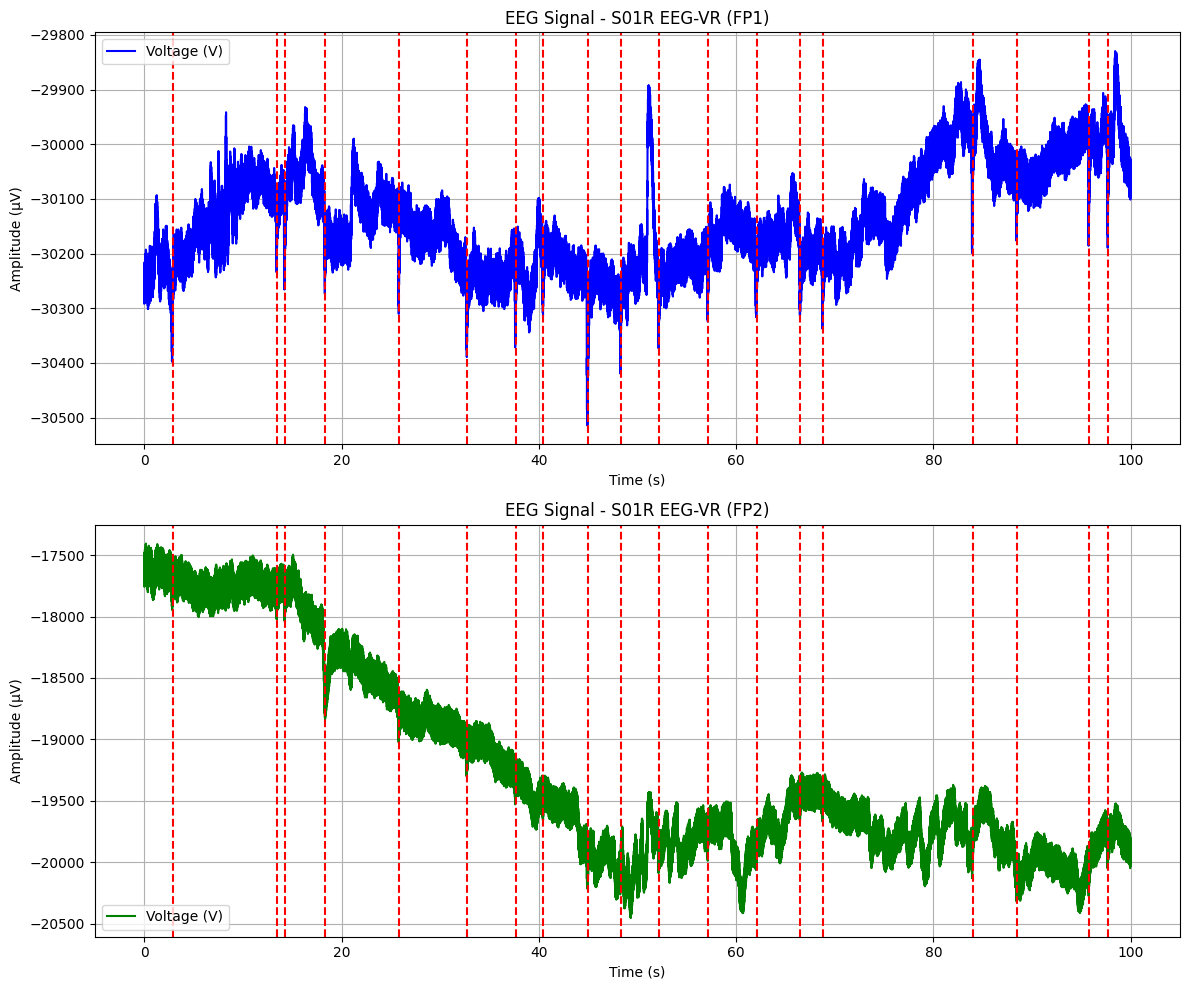

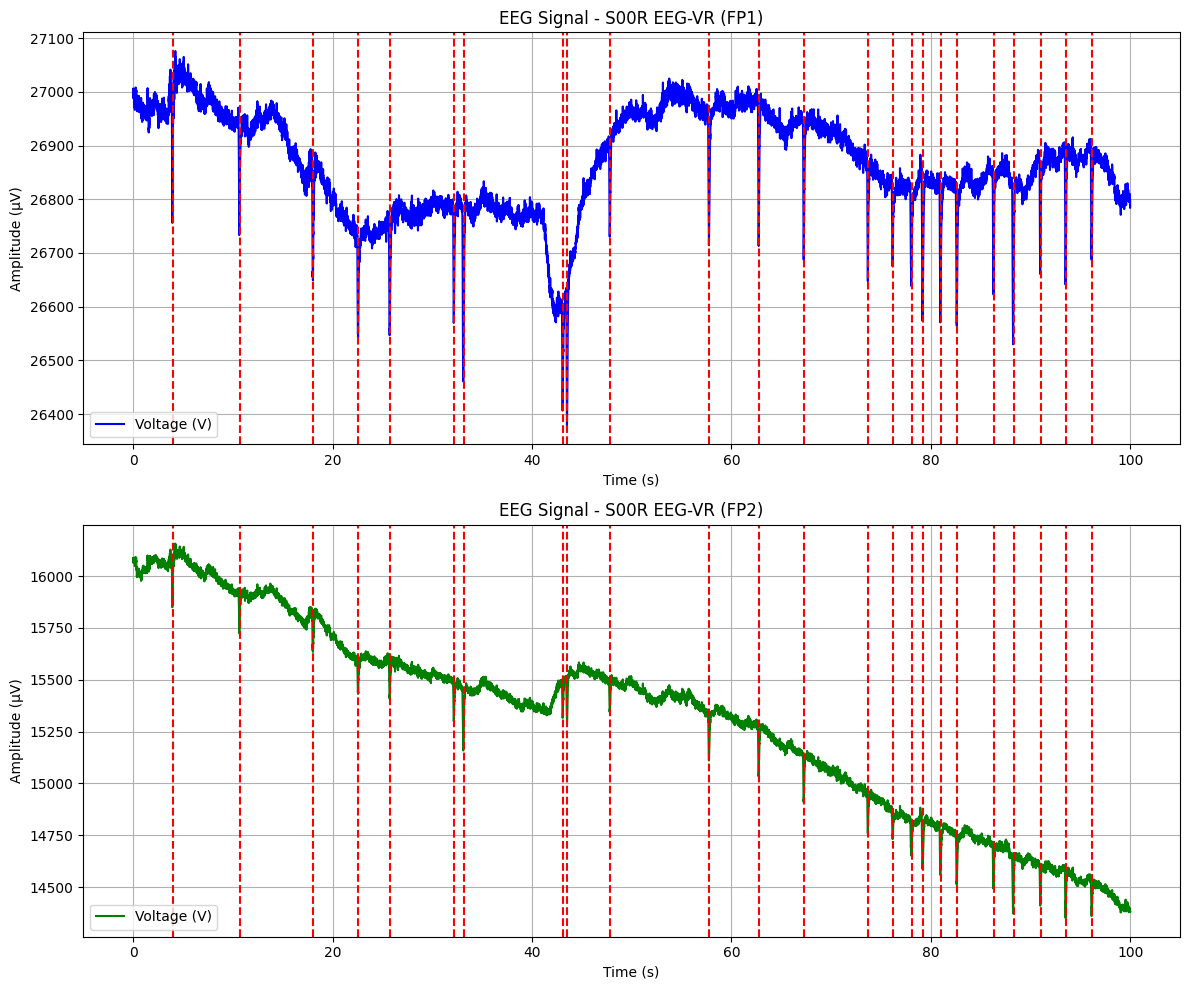

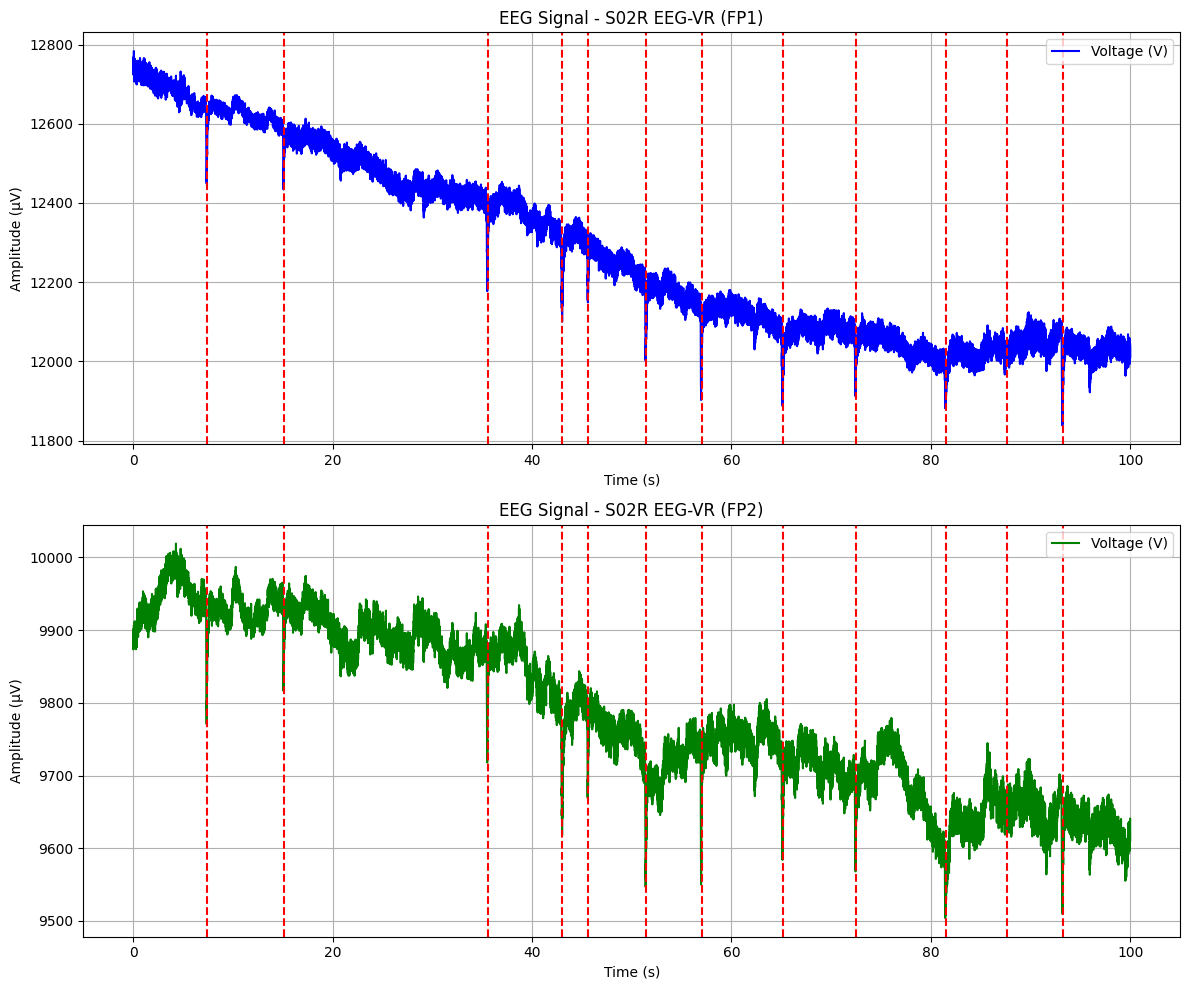

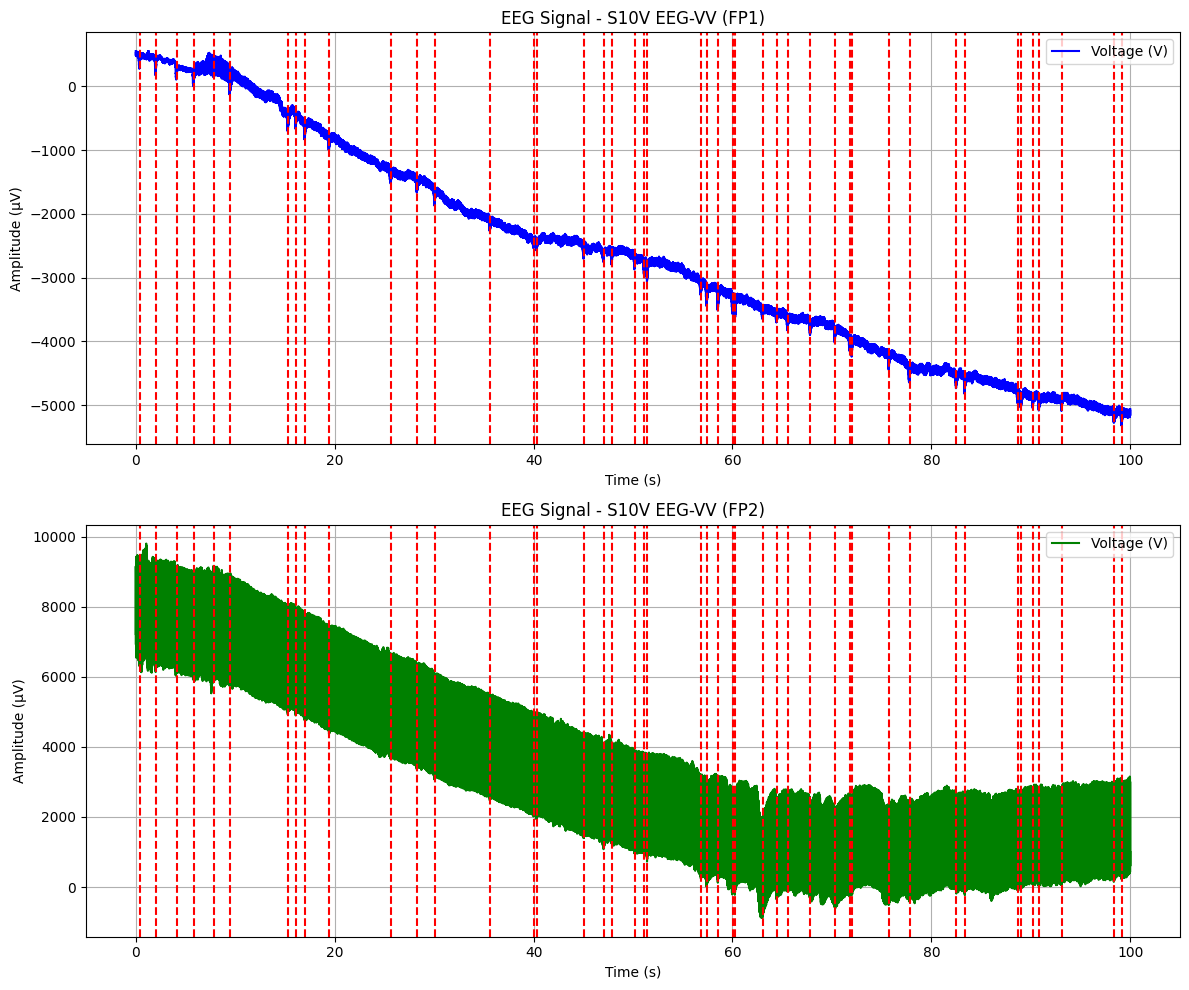

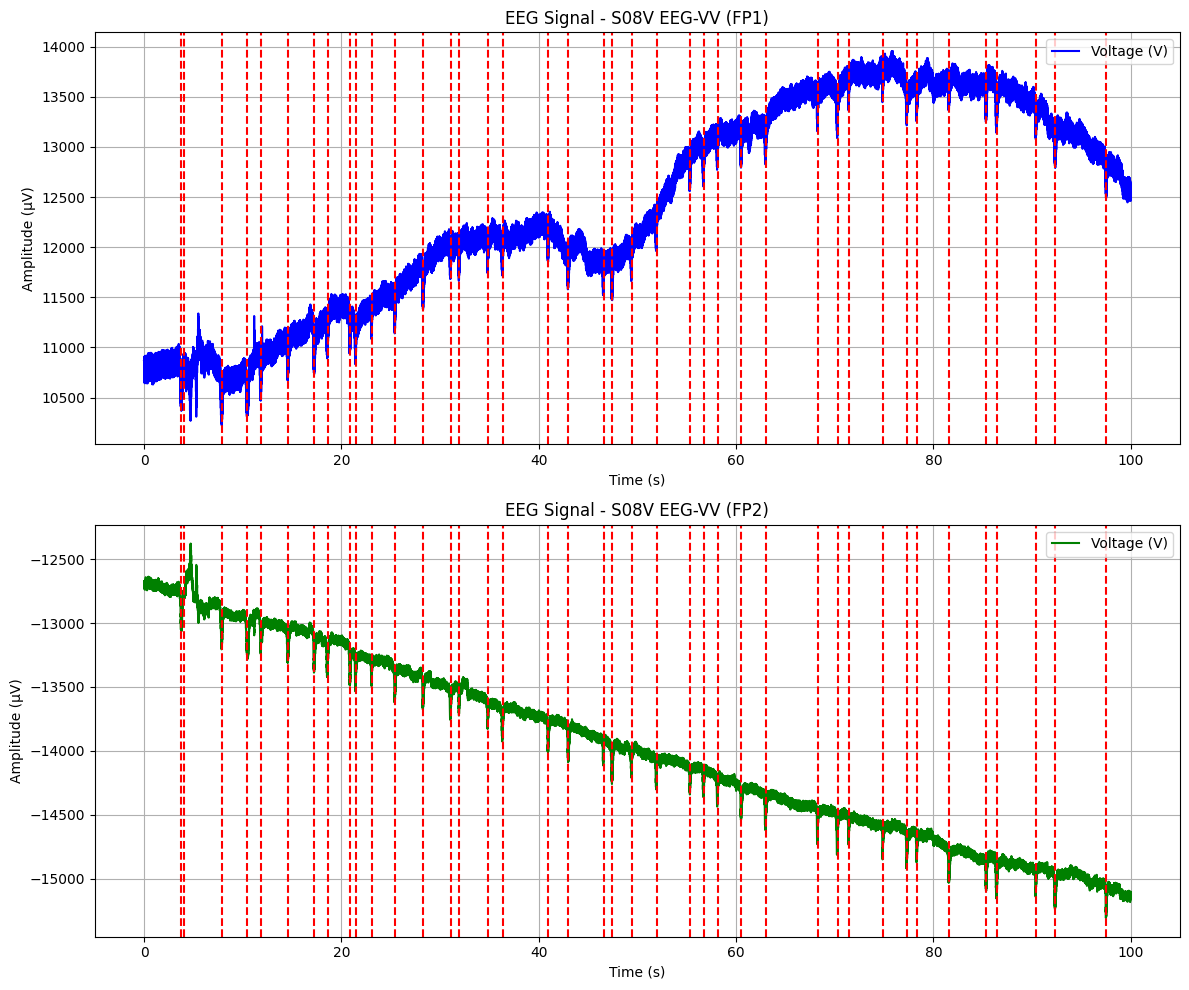

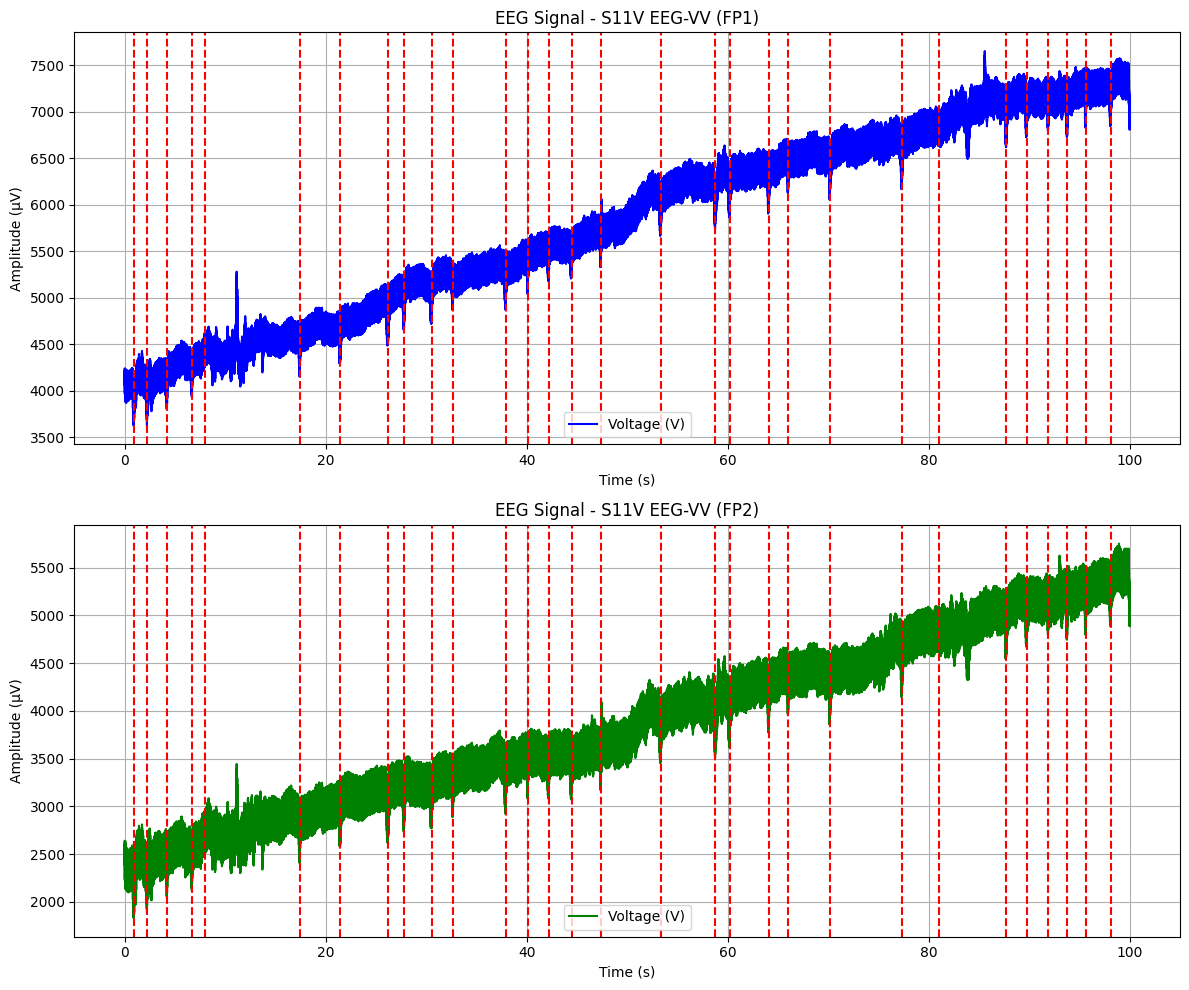

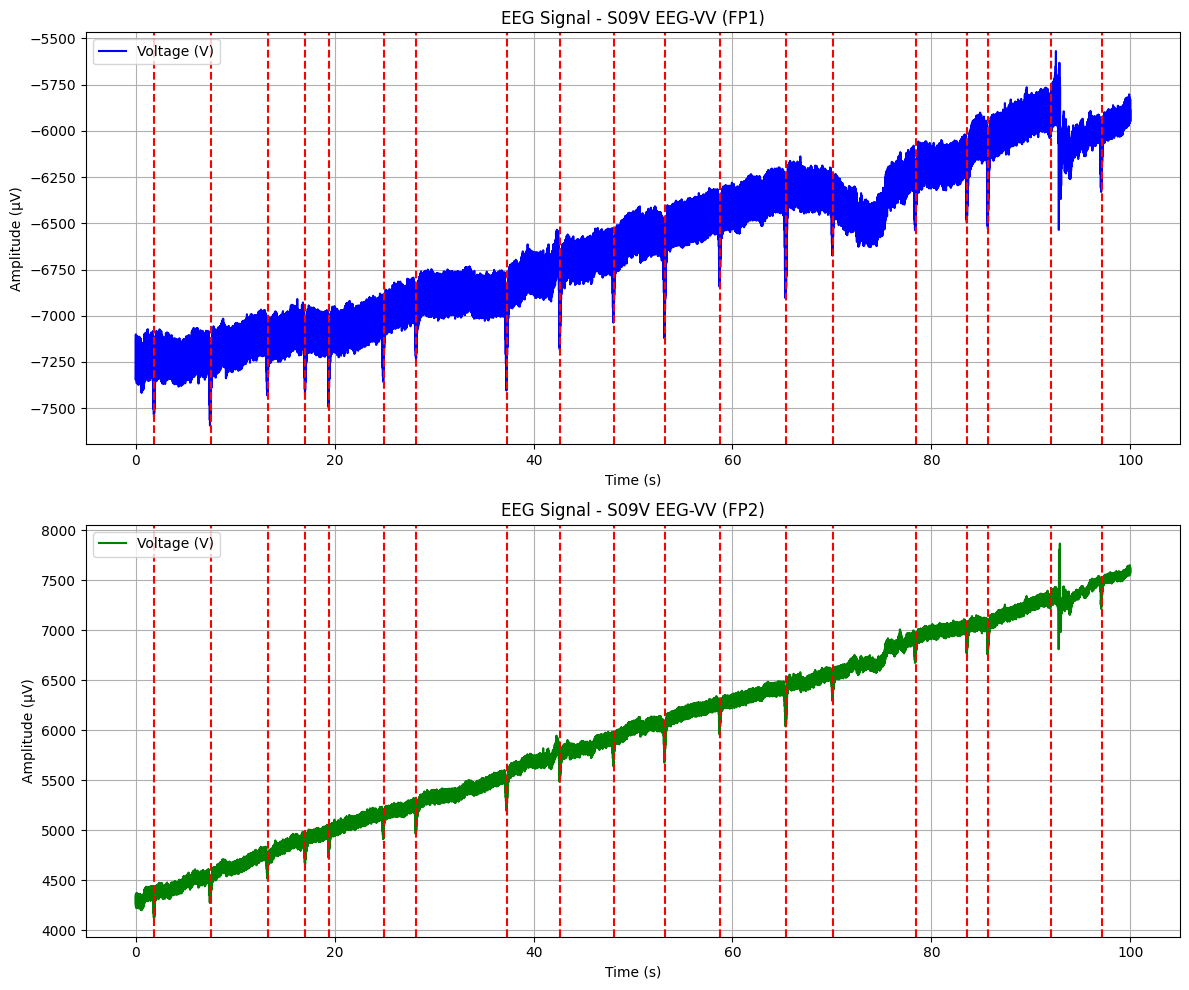

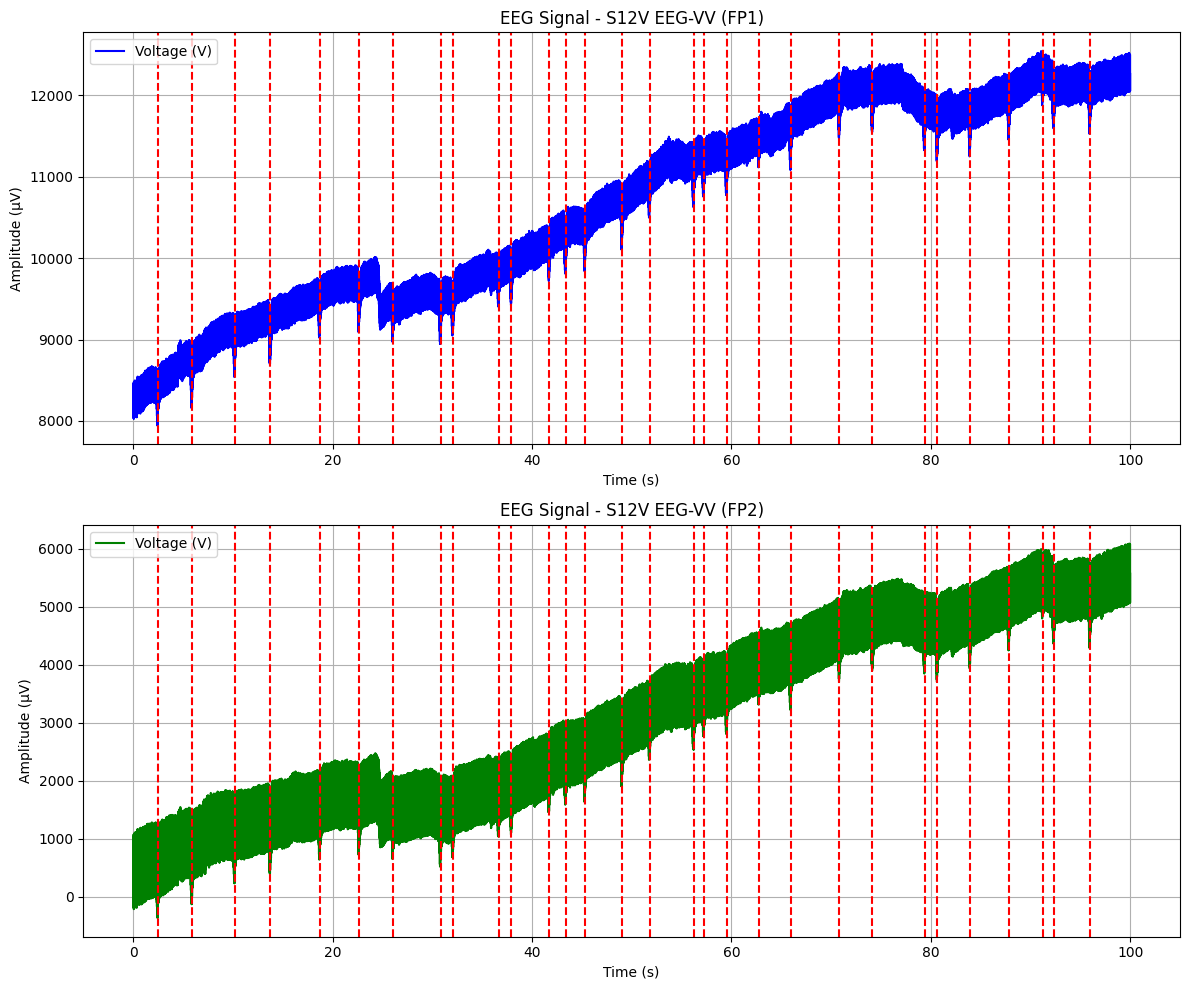

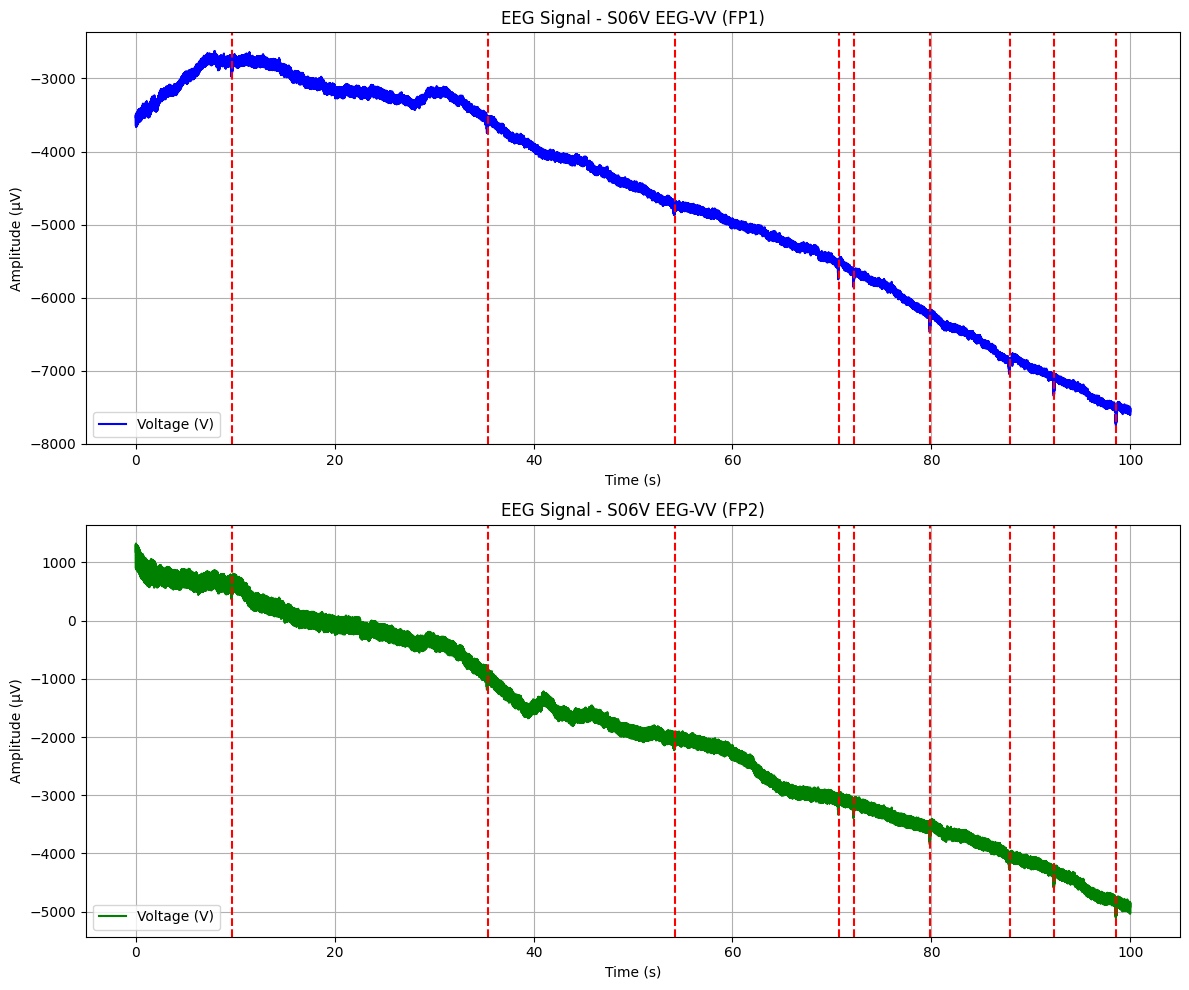

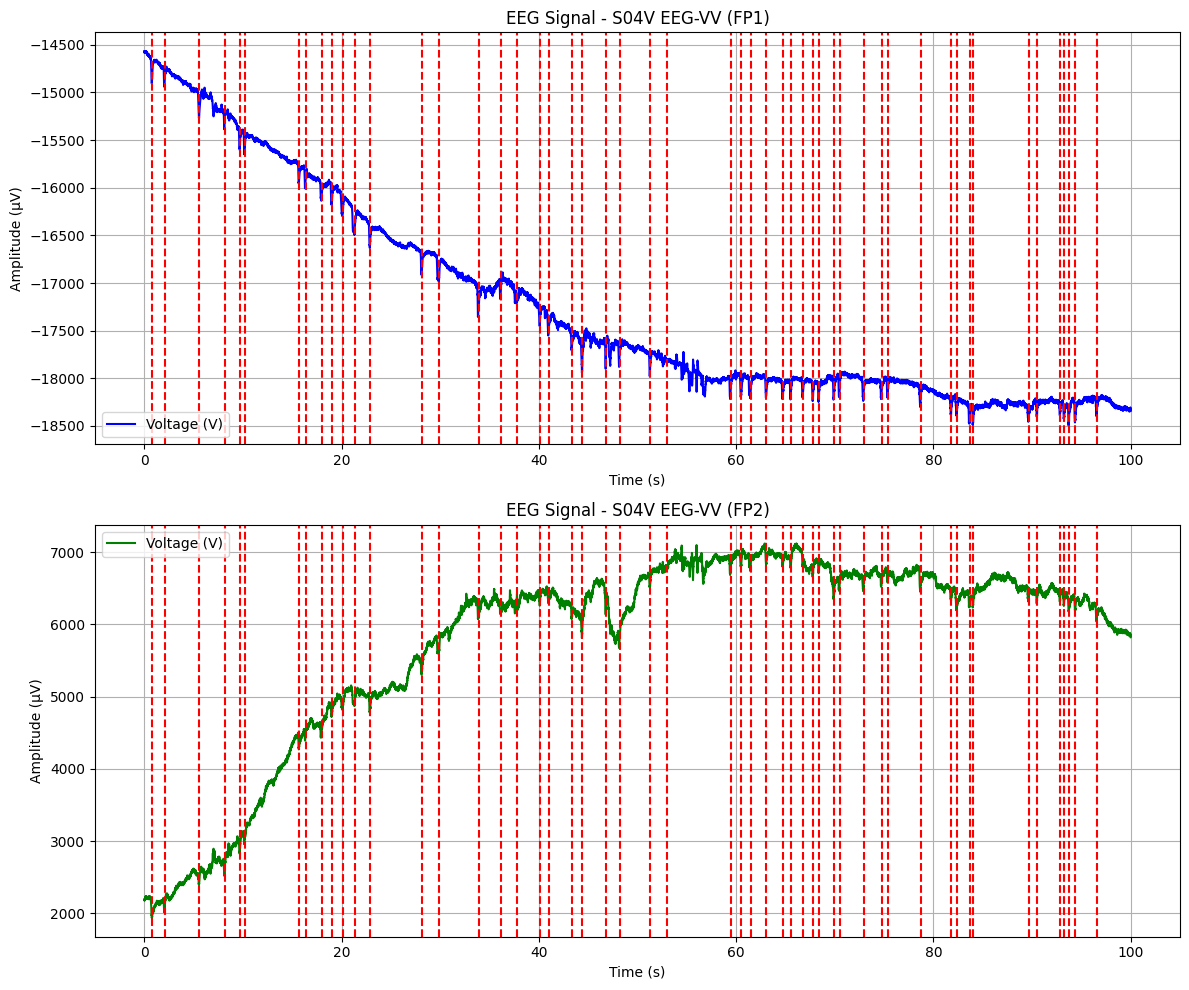

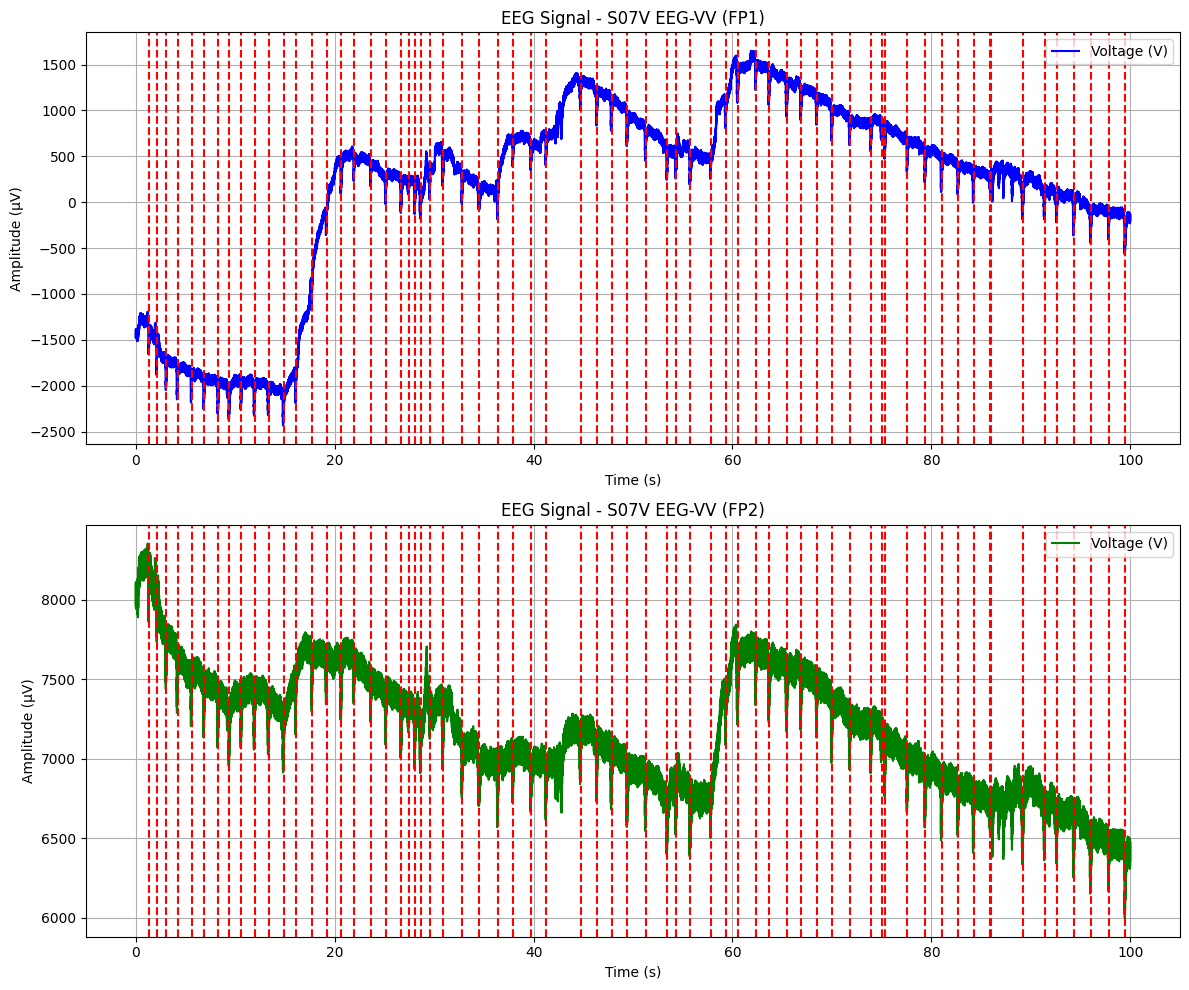

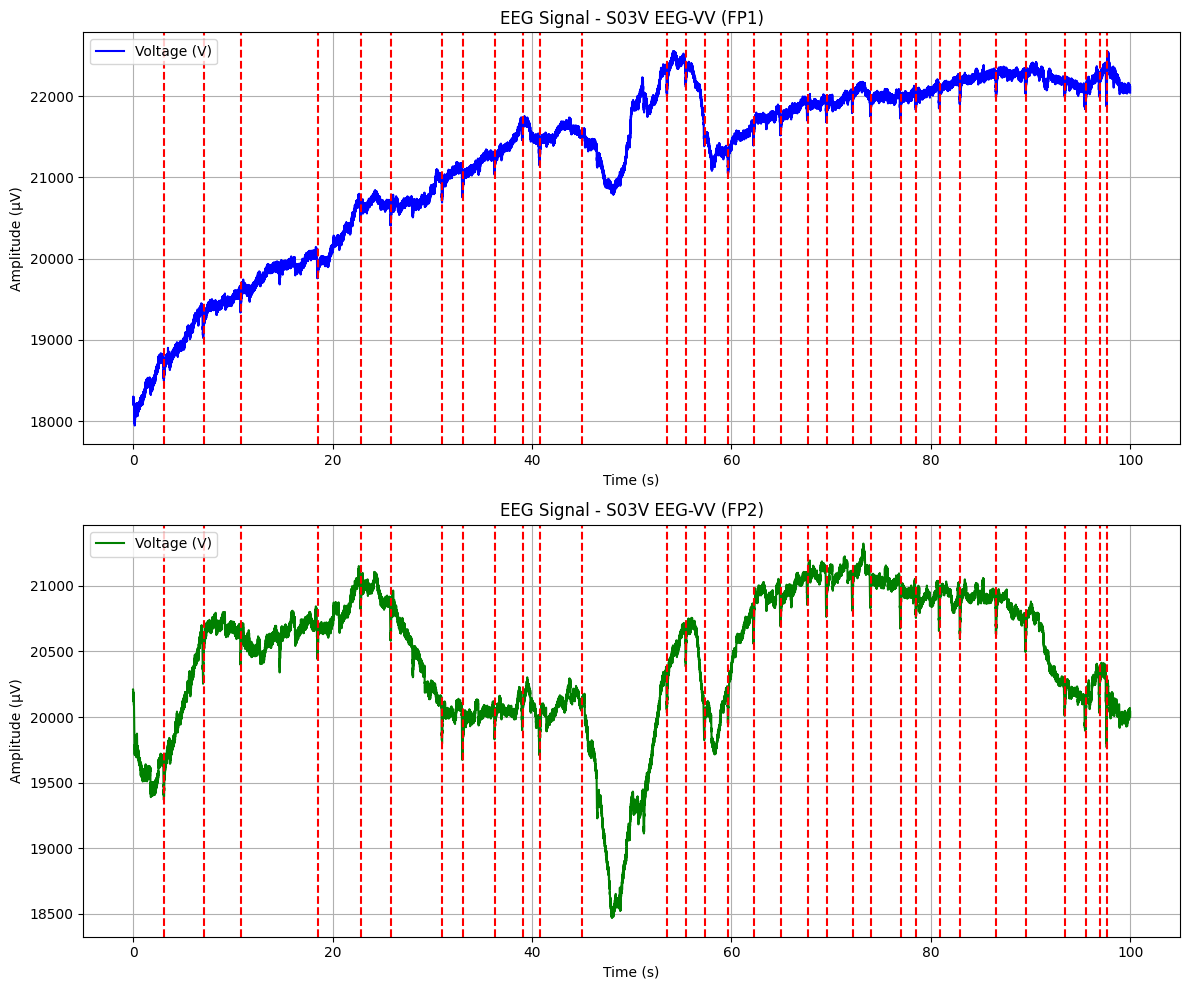

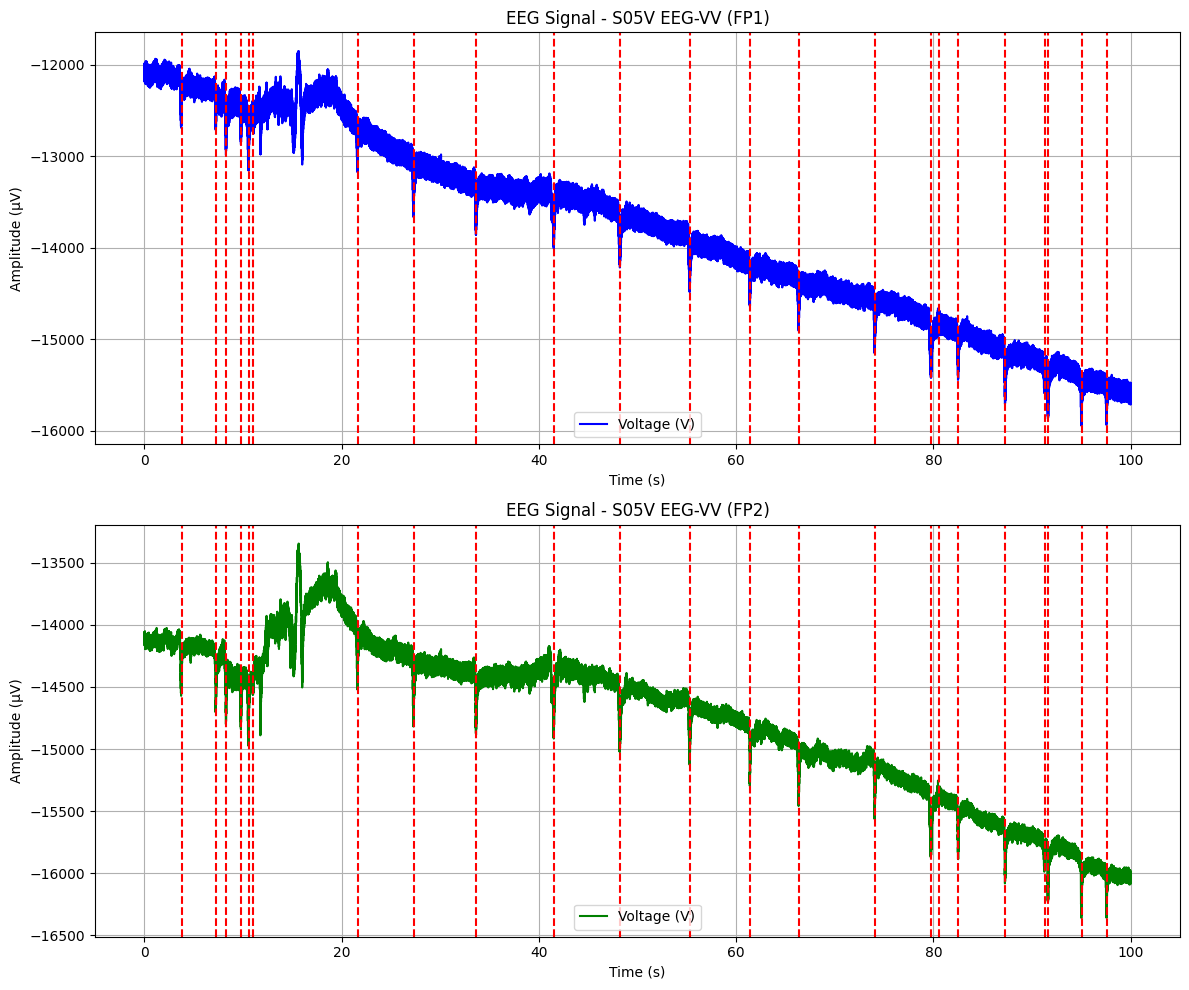

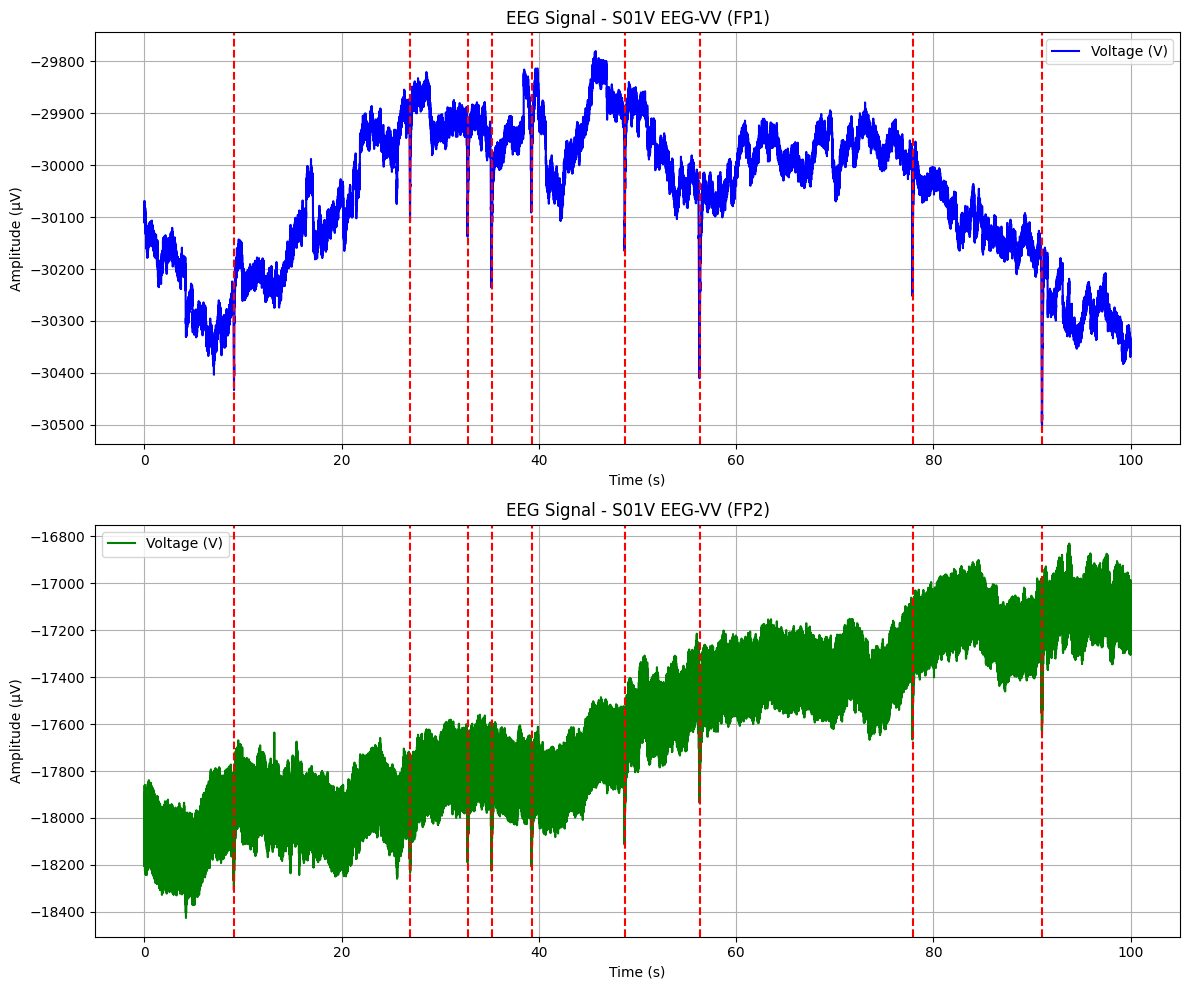

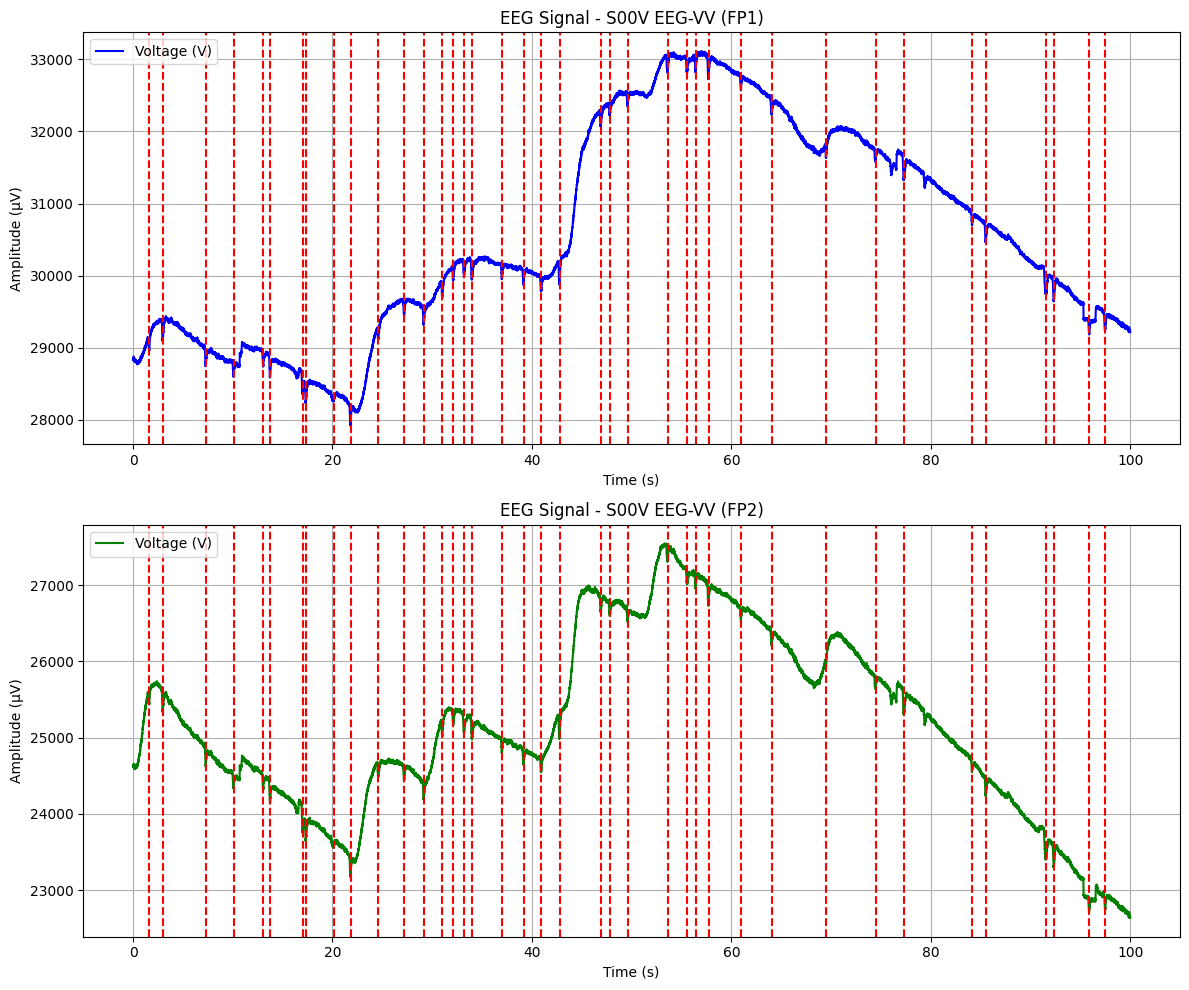

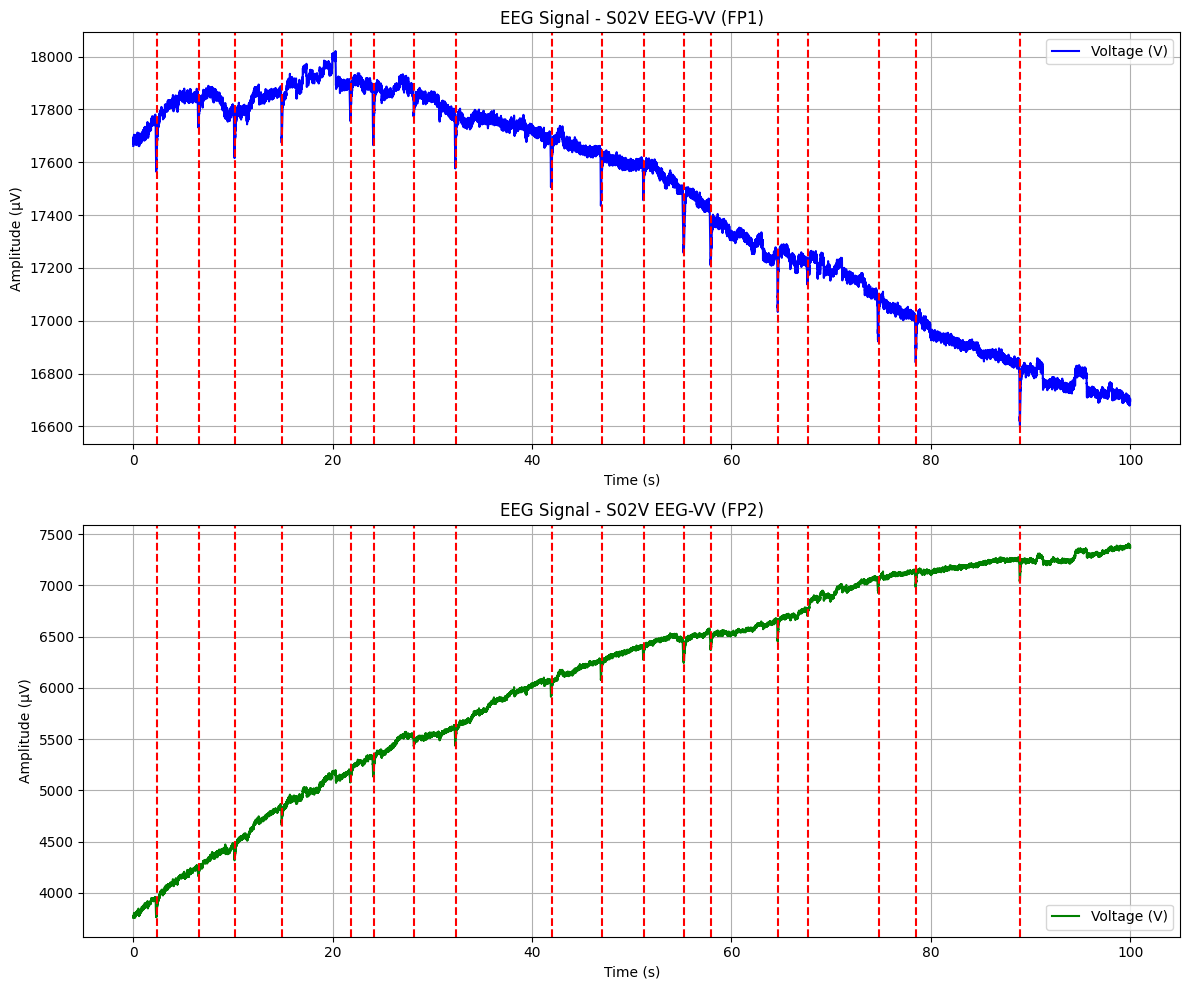


Displaying a section of the consolidated EEG DataFrame:
   Time (s)   Voltage (V)           Dataset  Blink
0  0.000000  16046.741211  S16 EEG-IO (FP1)      0
1  0.003906  16090.081055  S16 EEG-IO (FP1)      0
2  0.007812  16099.849609  S16 EEG-IO (FP1)      0
3  0.011719  16047.590820  S16 EEG-IO (FP1)      0
4  0.015625  16027.429688  S16 EEG-IO (FP1)      0
5  0.019531  16060.018555  S16 EEG-IO (FP1)      0
6  0.023438  16063.863281  S16 EEG-IO (FP1)      0
7  0.027344  16031.810547  S16 EEG-IO (FP1)      0
8  0.031250  16026.557617  S16 EEG-IO (FP1)      0
9  0.035156  16059.951172  S16 EEG-IO (FP1)      0
All data successfully loaded and saved to the database as separate tables for each channel.


In [ ]:
# Loops through each folder in the path pulling both data and label files
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    files = os.listdir(folder_path)

    data_files = [f for f in files if 'data' in f.lower() and f.endswith('.csv')]
    label_files = [f for f in files if 'labels' in f.lower() and f.endswith('.csv')]

    label_dict = {label_file.replace('_labels.csv', ''): label_file for label_file in label_files}

    for data_file in data_files:
        base_name = data_file.replace('_data.csv', '')
        data_path = os.path.join(folder_path, data_file)

        # In EEG-IO the data uses a ; to seperate data the first coulumn is already in time, so we don't do anything to it
        if folder == 'EEG-IO':
            data = pd.read_csv(data_path, sep=';', skiprows=0, header=0, usecols=[0, 1, 2], names=['Time (s)', 'FP1', 'FP2'])
        # The other folders however have weird header rows and use a , to seperate files, They also have an index instead of time that only counts to 255 so we need to convert that to time
        else:
            data = pd.read_csv(data_path, sep=',', skiprows=5, header=None, usecols=[0, 1, 2], names=['Index', 'FP1', 'FP2'])
            sample_rate = 250
            time_per_sample = 1 / sample_rate
            cumulative_time = []
            last_time = 0
            for idx, row in data.iterrows():
                if idx > 0 and data.loc[idx, 'Index'] < data.loc[idx - 1, 'Index']:
                    last_time += (data.loc[idx - 1, 'Index'] + 1) * time_per_sample
                current_time = last_time + data.loc[idx, 'Index'] * time_per_sample
                cumulative_time.append(current_time)
            data['Time (s)'] = cumulative_time
            data.drop(columns=['Index'], inplace=True)

        data = data[data['Time (s)'] <= 100].copy()

        # IF the file is labeled it will attach that file to the data in order to keep everything contained
        if base_name in label_dict:
            label_file = label_dict[base_name]
            labels_path = os.path.join(folder_path, label_file)
            labels = pd.read_csv(labels_path, sep=';', header=None, names=['blink_time'], skiprows=1)
            labels['blink_time'] = labels['blink_time'].str.split(',').str[0]
            labels = labels[labels['blink_time'].str.replace('.', '', 1).str.isnumeric()]
            labels['blink_time'] = labels['blink_time'].astype(float)
            labels = labels[(labels['blink_time'] > 0) & (labels['blink_time'] <= 100)]
        else:
            print(f'No corresponding label file found for {data_file} in folder {folder}. Skipping blink marking.')
            labels = pd.DataFrame(columns=['blink_time'])

        data['Blink'] = 0
        for blink_time in labels['blink_time']:
            idx = (np.abs(data['Time (s)'] - blink_time)).idxmin()
            data.at[idx, 'Blink'] = 1

        # Split FP1 and FP2 into 2 different tables to allow future code to work with them without having to impliment a way to split them up later
        data_FP1 = data[['Time (s)', 'FP1', 'Blink']].copy()
        data_FP1.rename(columns={'FP1': 'Voltage (V)'}, inplace=True)
        data_FP1['Dataset'] = f"{base_name} {folder} (FP1)"
        data_FP2 = data[['Time (s)', 'FP2', 'Blink']].copy()
        data_FP2.rename(columns={'FP2': 'Voltage (V)'}, inplace=True)
        data_FP2['Dataset'] = f"{base_name} {folder} (FP2)"
        data_FP1 = data_FP1[['Time (s)', 'Voltage (V)', 'Dataset', 'Blink']]
        data_FP2 = data_FP2[['Time (s)', 'Voltage (V)', 'Dataset', 'Blink']]
        all_data_eeg.append(data_FP1)
        all_data_eeg.append(data_FP2)
        table_name_fp1 = f"{base_name}_{folder}_FP1".replace(" ", "_").replace("-", "_")
        table_name_fp2 = f"{base_name}_{folder}_FP2".replace(" ", "_").replace("-", "_")
        data_FP1.to_sql(table_name_fp1, conn, if_exists='replace', index=False)
        data_FP2.to_sql(table_name_fp2, conn, if_exists='replace', index=False)


        # Plot the data to make sure it's all being pulled correctly
        plt.figure(figsize=(12, 10))

        # Plot FP1 signal.
        plt.subplot(2, 1, 1)
        plt.plot(data_FP1['Time (s)'], data_FP1['Voltage (V)'], label='Voltage (V)', color='blue')
        plt.title(f'EEG Signal - {data_FP1["Dataset"].iloc[0]}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.grid(True)
        plt.legend()
        for blink_time in labels['blink_time']:
            plt.axvline(x=blink_time, color='red', linestyle='--')

        # Plot FP2 signal.
        plt.subplot(2, 1, 2)
        plt.plot(data_FP2['Time (s)'], data_FP2['Voltage (V)'], label='Voltage (V)', color='green')
        plt.title(f'EEG Signal - {data_FP2["Dataset"].iloc[0]}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.grid(True)
        plt.legend()
        for blink_time in labels['blink_time']:
            plt.axvline(x=blink_time, color='red', linestyle='--')

        plt.tight_layout()
        plt.show()

consolidated_eeg_data = pd.concat(all_data_eeg, ignore_index=True)
print("\nDisplaying a section of the consolidated EEG DataFrame:")
print(consolidated_eeg_data.head(10))

conn.close()
print("All data successfully loaded and saved to the database as separate tables for each channel.")